In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import shapiro
import statsmodels.api as sm
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

## Wczytanie danych po transformacji

In [2]:
# Wczytaj dane z pliku CSV
data = pd.read_csv('Prognoza_transformed.csv', sep=',' ,parse_dates=['date'])

data.head(5)


date    ilosc  articles  customers  year  month  day  day_of_year  \
0 2022-01-03    7.072         7          3  2022      1    3            3   
1 2022-01-04  230.061       415         35  2022      1    4            4   
2 2022-01-05  115.141       411         37  2022      1    5            5   
3 2022-01-10  148.733       434         47  2022      1   10           10   
4 2022-01-11  505.648       896         53  2022      1   11           11   

   week_of_year  quarter  ...  is_last_days  is_weak_month  is_saturday  \
0             1        1  ...             0              0            0   
1             1        1  ...             0              0            0   
2             1        1  ...             0              0            0   
3             2        1  ...             0              0            0   
4             2        1  ...             0              0            0   

   is_first_days  ilosc_log  ilosc_log_std  customers_log  customers_log_std  \
0              1   2.088401      -3.619092       1.386294          -6.906660   
1              1   5.442682      -0.377503       3.583519          -1.220855   
2              1   4.754805      -1.042270       3.637586          -1.080944   
3              0   5.008854      -0.796756       3.871201          -0.476414   
4              0   6.227816       0.381254       3.988984          -0.171624   

   articles_log  articles_log_std  
0      2.079442         -6.062106  
1      6.030685         -0.641179  
2      6.021023         -0.654435  
3      6.075346         -0.579906  
4      6.799056          0.412991  

[5 rows x 33 columns]

In [3]:
data.describe()

date        ilosc     articles   customers  \
count                            614   614.000000   614.000000  614.000000   
mean   2023-03-24 21:36:56.286644992   639.469485   823.167752   59.705212   
min              2022-01-03 00:00:00     0.221000     1.000000    1.000000   
25%              2022-08-13 00:00:00   182.104000   488.500000   52.000000   
50%              2023-03-22 12:00:00   260.117000   636.500000   59.000000   
75%              2023-11-01 12:00:00   556.920000   862.750000   67.000000   
max              2024-06-18 00:00:00  7589.803000  4577.000000  124.000000   
std                              NaN  1023.360409   634.598299   16.194356   

              year       month         day  day_of_year  week_of_year  \
count   614.000000  614.000000  614.000000   614.000000    614.000000   
mean   2022.780130    5.894137   15.983713   164.153094     23.843648   
min    2022.000000    1.000000    1.000000     2.000000      1.000000   
25%    2022.000000    3.000000    8.250000    74.000000     11.000000   
50%    2023.000000    5.000000   16.000000   150.500000     22.000000   
75%    2023.000000    9.000000   23.000000   251.750000     36.000000   
max    2024.000000   12.000000   31.000000   364.000000     52.000000   
std       0.739602    3.415758    8.684035   104.116602     14.839379   

          quarter  ...  is_last_days  is_weak_month  is_saturday  \
count  614.000000  ...    614.000000     614.000000   614.000000   
mean     2.301303  ...      0.097720       0.275244     0.003257   
min      1.000000  ...      0.000000       0.000000     0.000000   
25%      1.000000  ...      0.000000       0.000000     0.000000   
50%      2.000000  ...      0.000000       0.000000     0.000000   
75%      3.000000  ...      0.000000       1.000000     0.000000   
max      4.000000  ...      1.000000       1.000000     1.000000   
std      1.109987  ...      0.297178       0.447001     0.057026   

       is_first_days   ilosc_log  ilosc_log_std  customers_log  \
count     614.000000  614.000000     614.000000     614.000000   
mean        0.148208    5.833309       0.000000       4.055307   
min         0.000000    0.199670      -5.444369       0.693147   
25%         0.000000    5.210054      -0.602315       3.970292   
50%         0.000000    5.564965      -0.259328       4.094345   
75%         0.000000    6.324216       0.474414       4.219508   
max         1.000000    8.934693       2.997189       4.828314   
std         0.355596    1.035608       1.000815       0.386755   

       customers_log_std  articles_log  articles_log_std  
count       6.140000e+02    614.000000      6.140000e+02  
mean        1.643275e-15      6.498032     -2.430195e-16  
min        -8.700332e+00      0.693147     -7.964039e+00  
25%        -2.199942e-01      6.193383     -4.179651e-01  
50%         1.010196e-01      6.457554     -5.553441e-02  
75%         4.249069e-01      6.761283      3.611684e-01  
max         2.000327e+00      8.429018      2.649224e+00  
std         1.000815e+00      0.729481      1.000815e+00  

[8 rows x 33 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               614 non-null    datetime64[ns]
 1   ilosc              614 non-null    float64       
 2   articles           614 non-null    int64         
 3   customers          614 non-null    int64         
 4   year               614 non-null    int64         
 5   month              614 non-null    int64         
 6   day                614 non-null    int64         
 7   day_of_year        614 non-null    int64         
 8   week_of_year       614 non-null    int64         
 9   quarter            614 non-null    int64         
 10  season             614 non-null    int64         
 11  month_sin          614 non-null    float64       
 12  month_cos          614 non-null    float64       
 13  day_sin            614 non-null    float64       
 14  day_cos   

## Podział danych

In [31]:
data['date'] = pd.to_datetime(data['date'])

In [55]:
train_start_date = '2022-01-02'
train_end_date = '2023-12-31'
test_start_date = '2024-01-01'
test_end_date = '2024-06-18'

In [56]:
train_data = data[(data['date'] >= train_start_date) & (data['date'] <= train_end_date)]
test_data = data[(data['date'] >= test_start_date) & (data['date'] <= test_end_date)]

In [57]:
dependent_variable = 'ilosc'
X_train = train_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_train = train_data[dependent_variable]
X_test = test_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_test = test_data[dependent_variable]

In [58]:
dependent_variable = 'ilosc_log_std'
X_train_log = train_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_train_log = train_data[dependent_variable]
X_test_log = test_data.drop(columns=['ilosc', 'ilosc_log', 'ilosc_log_std'])
y_test_log = test_data[dependent_variable]

### Model regresji liniowej

* Cel: odkrycie zależności pomiędzy zmiennymi

In [10]:
# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X_train[['customers', 'articles', 'is_last_days', 'is_first_days']])

# Dopasowanie modelu regresji liniowej
model = sm.OLS(y_train, X).fit()

# Podsumowanie modelu
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     1092.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          1.11e-243
Time:                        21:48:21   Log-Likelihood:                -3598.9
No. Observations:                 499   AIC:                             7208.
Df Residuals:                     494   BIC:                             7229.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           162.8742     59.393      2.742

In [11]:
# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X_train_log[['customers_log_std', 'articles_log_std', 'is_last_days', 'is_first_days']])

# Dopasowanie modelu regresji liniowej
model = sm.OLS(y_train_log, X).fit()

# Podsumowanie modelu
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:          ilosc_log_std   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     394.5
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          3.01e-152
Time:                        21:48:30   Log-Likelihood:                -365.38
No. Observations:                 499   AIC:                             740.8
Df Residuals:                     494   BIC:                             761.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0153      0.02

Macierz korelacji:

                   articles_log_std  customers_log_std  ilosc_log_std  articles  customers  ilosc
articles_log_std               1.00               0.79           0.83      0.77       0.70   0.63
customers_log_std              0.79               1.00           0.50      0.40       0.86   0.21
ilosc_log_std                  0.83               0.50           1.00      0.82       0.54   0.81
articles                       0.77               0.40           0.82      1.00       0.56   0.92
customers                      0.70               0.86           0.54      0.56       1.00   0.34
ilosc                          0.63               0.21           0.81      0.92       0.34   1.00


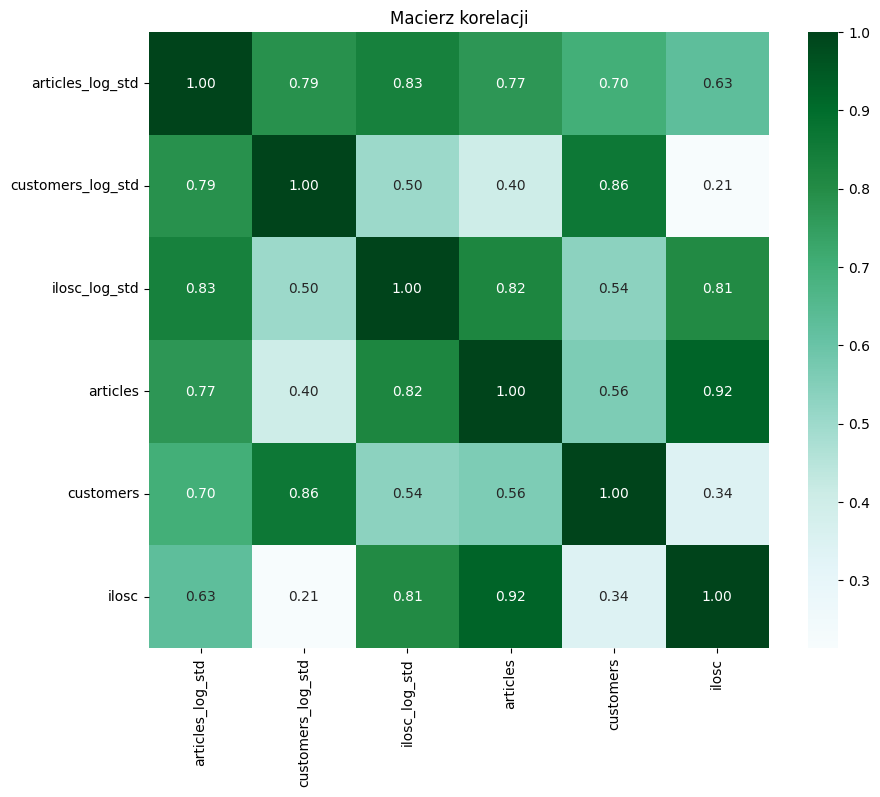

In [12]:
# Obliczanie macierzy korelacji
# tylko dla zmiennych niezależnych
correlation_matrix = data[['articles_log_std', 'customers_log_std', 'ilosc_log_std', 'articles', 'customers', 'ilosc']].corr()
#correlation_matrix = data.corr()

# Ładny wydruk macierzy korelacji
print("Macierz korelacji:\n")
print(correlation_matrix.to_string(float_format="%.2f"))

# Wizualizacja macierzy korelacji za pomocą mapy cieplnej
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuGn', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()



## Modele

### Regresja wieloraka

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     1092.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          1.11e-243
Time:                        21:53:27   Log-Likelihood:                -3598.9
No. Observations:                 499   AIC:                             7208.
Df Residuals:                     494   BIC:                             7229.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           162.8742     59.393      2.742

C:\Users\poczt\AppData\Local\Temp\ipykernel_16240\2513856142.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = model_multi.predict(X_test)


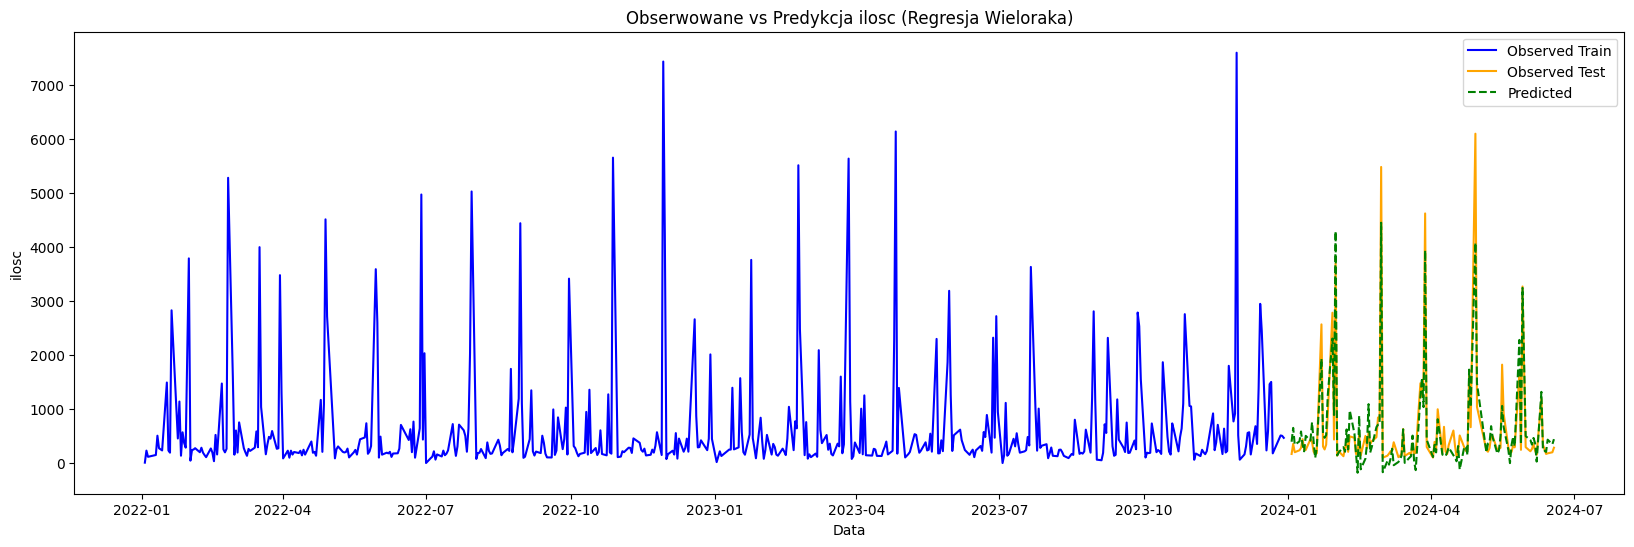

In [24]:

# Dodanie stałej do modelu (intercept)
X_train = sm.add_constant(X_train[['customers', 'articles', 'is_last_days', 'is_first_days']])
X_test = sm.add_constant(X_test[['customers', 'articles', 'is_last_days', 'is_first_days']])

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y_train, X_train).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na zbiorze testowym
test_data['predicted'] = model_multi.predict(X_test)

# Wykres
plt.figure(figsize=(20, 6))
plt.plot(train_data['date'], train_data['ilosc'], label='Observed Train', color='blue')
plt.plot(test_data['date'], test_data['ilosc'], label='Observed Test', color='orange')
plt.plot(test_data['date'], test_data['predicted'], label='Predicted', linestyle='--', color='green')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     204.8
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.08e-103
Time:                        21:54:30   Log-Likelihood:                -3925.5
No. Observations:                 499   AIC:                             7861.
Df Residuals:                     494   BIC:                             7882.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               546.6654     32.81

C:\Users\poczt\AppData\Local\Temp\ipykernel_16240\3784867843.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = model_multi.predict(X_test)


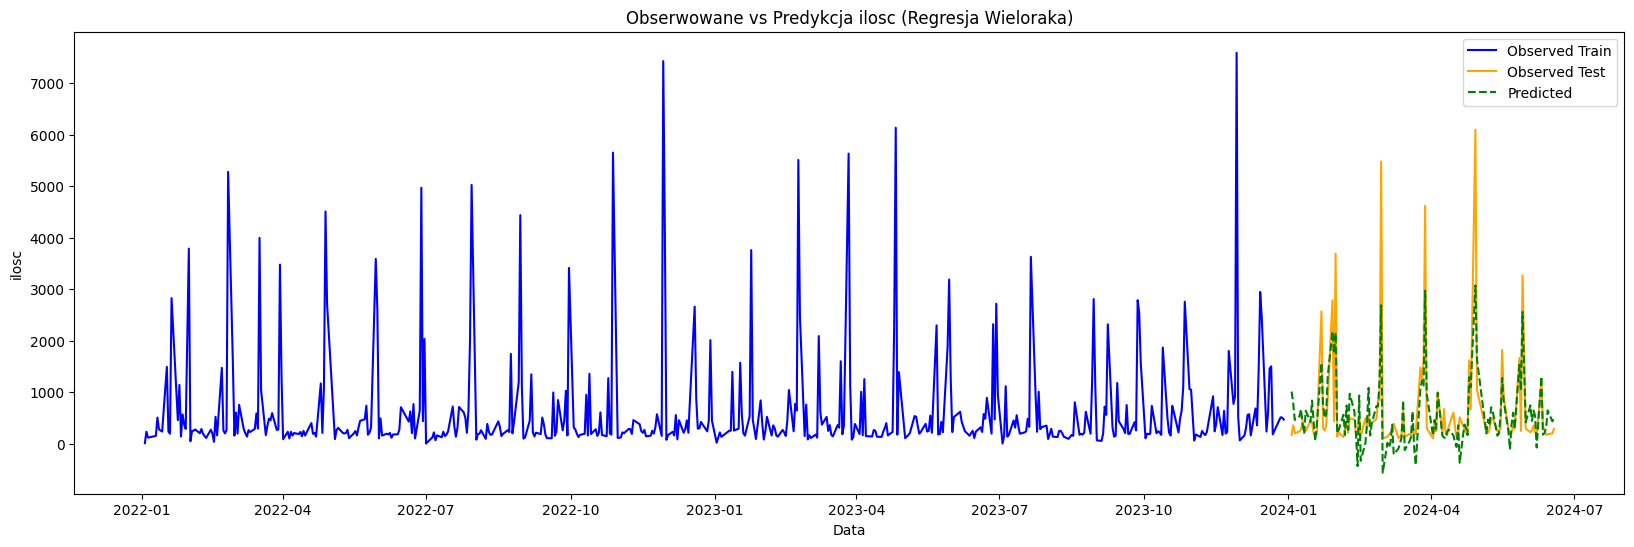

In [25]:
# Dodanie stałej do modelu (intercept)
X_train = sm.add_constant(X_train_log[['customers_log_std', 'articles_log_std', 'is_last_days', 'is_first_days']])
X_test = sm.add_constant(X_test_log[['customers_log_std', 'articles_log_std', 'is_last_days', 'is_first_days']])

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y_train, X_train).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na zbiorze testowym
test_data['predicted'] = model_multi.predict(X_test)

# Wykres
plt.figure(figsize=(20, 6))
plt.plot(train_data['date'], train_data['ilosc'], label='Observed Train', color='blue')
plt.plot(test_data['date'], test_data['ilosc'], label='Observed Test', color='orange')
plt.plot(test_data['date'], test_data['predicted'], label='Predicted', linestyle='--', color='green')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

## Model SARIMA

- Jeśli szereg czasowy ma zdefiniowaną sezonowość, powinniśmy użyć modelu **Seasonal ARIMA** (w skrócie **SARIMA**), który wykorzystuje różnicowanie sezonowe.

- Różnicowanie sezonowe jest podobne do zwykłego różnicowania, ale zamiast odejmować kolejne wartości, odejmujemy wartość z poprzedniego sezonu.

- Tak więc model będzie reprezentowany jako **SARIMA(p,d,q)x(P,D,Q)**, gdzie P, D i Q to odpowiednio terminy SAR, rząd różnicowania sezonowego i terminy SMA, a 'x' to częstotliwość szeregu czasowego. Jeśli model ma dobrze zdefiniowane wzorce sezonowe, należy ustawić D=1 dla danej częstotliwości 'x'.

- Powinniśmy ustawić parametry modelu tak, aby D nigdy nie przekraczało jednego. Całkowite różnicowanie 'd + D' nigdy nie powinno przekraczać 2. Powinniśmy starać się utrzymywać tylko terminy SAR lub SMA, jeśli model ma komponenty sezonowe.


In [42]:

# Sezonowy model ARIMA - dopasowanie krokowe auto-ARIMA
smodel = pm.auto_arima(y_train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=1, max_q=1, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

# Wyświetlenie podsumowania modelu
smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8515.543, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8322.127, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8513.576, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8496.986, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8277.076, Time=2.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.93 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8295.084, Time=1.87 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=8275.751, Time=4.26 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.10 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=8274.263, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  499
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood               -4132.189
Date:                             Mon, 24 Jun 2024   AIC                           8272.378
Time:                                     22:14:38   BIC                           8289.131
Sample:                                          0   HQIC                          8278.959
                                             - 499                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2273      0.044      5.128      0.000       0.140       0.314
ar.S.L12      -0.7291      0.037    -19.776      0.000      -0.801      -0.657
ar.S.L24      -0.3156      0.036     -8.728      0.000      -0.386      -0.245
sigma2      1.367e+06   3.78e+04     36.202      0.000    1.29e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2071.23
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             2.17
Prob(H) (two-sided):                  0.10   Kurtosis:                        12.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Dopasowanie krokowego auto-ARIMA z zmiennymi egzogenicznymi na zestawie treningowym
smodel_exo = pm.auto_arima(y_train, exogenous=X_train[['customers', 'articles']],##, 'month', 'is_first_days', 'is_last_days', 'day_of_year', 'week_of_year']], 
                       start_p=1, start_q=1, 
                       test='adf', max_p=1, max_q=1, m=12, 
                       start_P=0, seasonal=True, d=None, D=1, 
                       trace=True, error_action='ignore', 
                       suppress_warnings=True, stepwise=True)

# Wyświetlenie podsumowania modelu
print(smodel_exo.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8515.543, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8322.127, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8513.576, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8496.986, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8277.076, Time=2.12 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8295.084, Time=1.55 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=8275.751, Time=3.17 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=5.03 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=8274.263, T

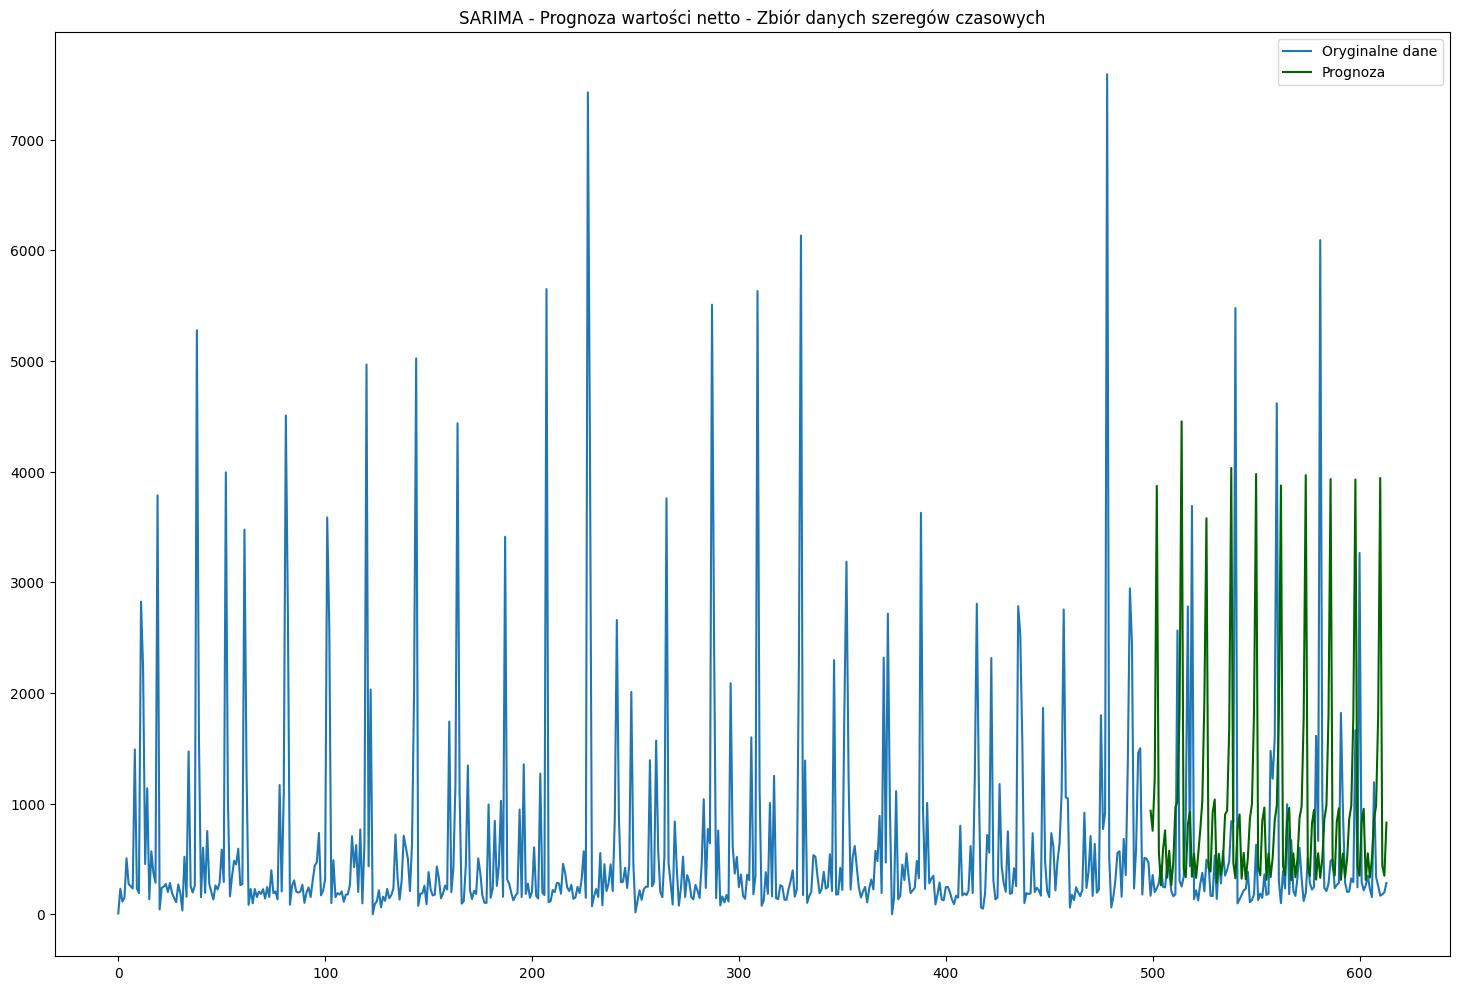

Średni błąd kwadratowy (MSE): 2308976.7540084906
Pierwiastek średniego błędu kwadratowego (RMSE): 1519.5317548536098
Średni absolutny błąd (MAE): 953.036480769207
Średni procentowy błąd absolutny (MAPE): 300.87467453517604%
Współczynnik determinacji (R^2): -1.3450084748150704


In [69]:
# Prognoza na zbiorze testowym
n_periods = len(y_test)
fitted, confint = smodel_exo.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = y_test.index  # Używamy tych samych dat co w zbiorze testowym

# Tworzenie serii do celów wykresu
fitted_series = pd.Series(fitted, index=index_of_fc)

# Wykres
plt.figure(figsize=(18, 12))
plt.plot(y, label='Oryginalne dane')
plt.plot(fitted_series, color='darkgreen', label='Prognoza')
plt.title("SARIMA - Prognoza wartości netto - Zbiór danych szeregów czasowych")
plt.legend()
plt.show()

# Obliczenie statystyk
mse = mean_squared_error(y_test, fitted)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, fitted)
mape = np.mean(np.abs((y_test - fitted) / y_test)) * 100
r2 = r2_score(y_test, fitted)

print(f'Średni błąd kwadratowy (MSE): {mse}')
print(f'Pierwiastek średniego błędu kwadratowego (RMSE): {rmse}')
print(f'Średni absolutny błąd (MAE): {mae}')
print(f'Średni procentowy błąd absolutny (MAPE): {mape}%')
print(f'Współczynnik determinacji (R^2): {r2}')


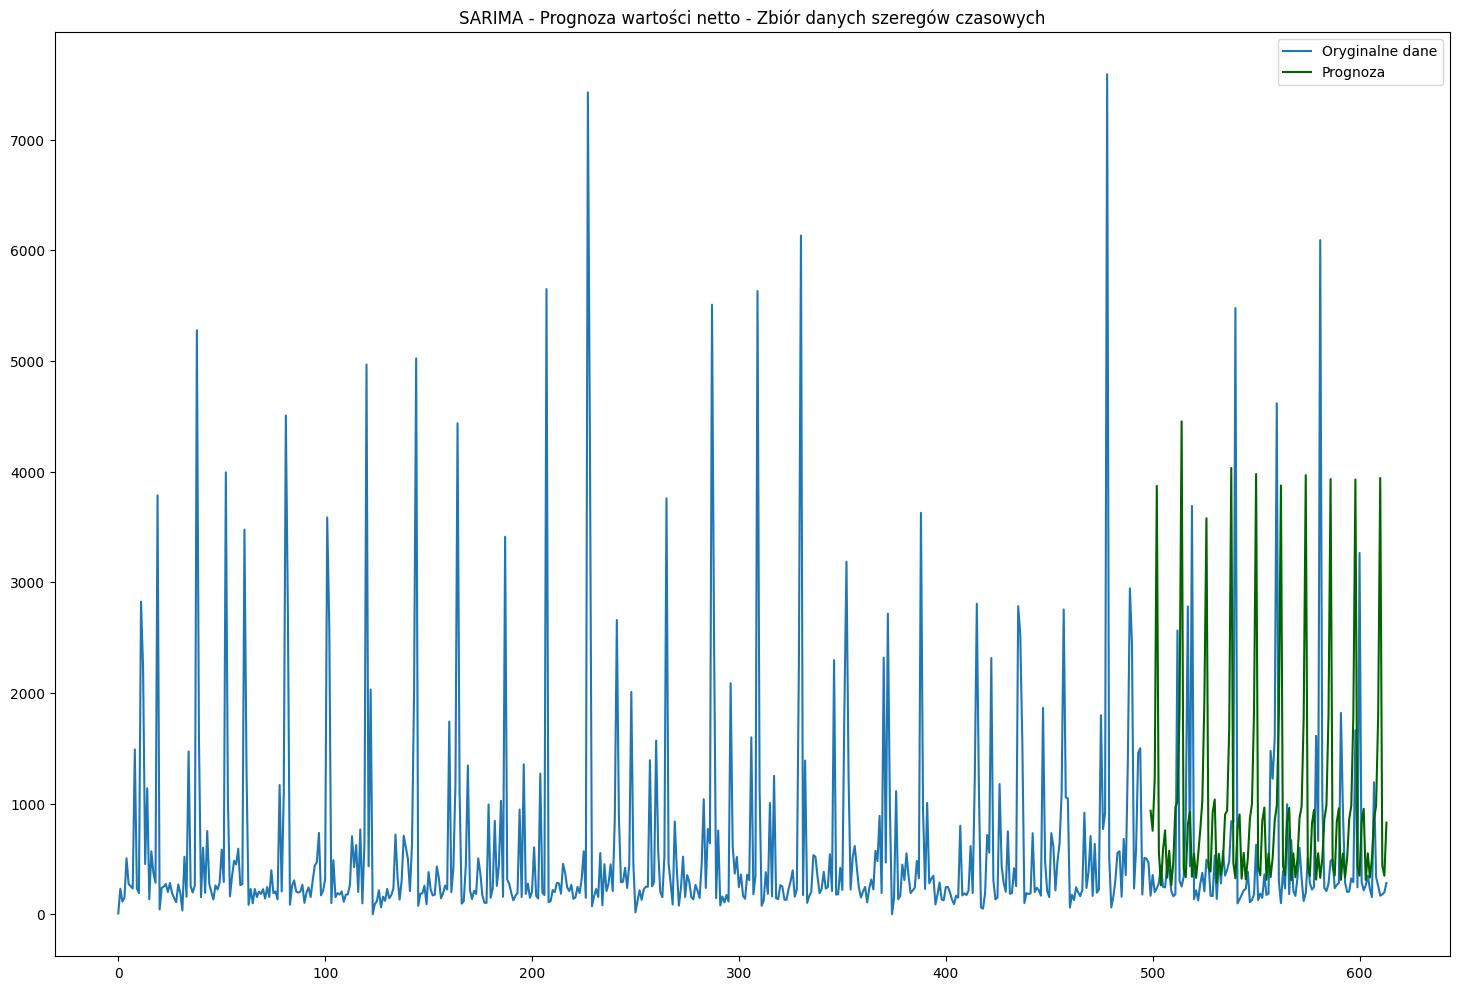

Średni błąd kwadratowy (MSE): 2308976.7540084906
Pierwiastek średniego błędu kwadratowego (RMSE): 1519.5317548536098
Średni absolutny błąd (MAE): 953.036480769207
Średni procentowy błąd absolutny (MAPE): 300.87467453517604%
Współczynnik determinacji (R^2): -1.3450084748150704


In [70]:
# Prognoza na zbiorze testowym
n_periods = len(y_test)
fitted, confint = smodel_exo.predict(n_periods=n_periods, exogenous=X_test[['customers', 'articles']], return_conf_int=True)
index_of_fc = y_test.index  # Używamy tych samych dat co w zbiorze testowym

# Tworzenie serii do celów wykresu
fitted_series = pd.Series(fitted, index=index_of_fc)

# Wykres
plt.figure(figsize=(18, 12))
plt.plot(y, label='Oryginalne dane')
plt.plot(fitted_series, color='darkgreen', label='Prognoza')
plt.title("SARIMA - Prognoza wartości netto - Zbiór danych szeregów czasowych")
plt.legend()
plt.show()

# Obliczenie statystyk
mse = mean_squared_error(y_test, fitted)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, fitted)
mape = np.mean(np.abs((y_test - fitted) / y_test)) * 100
r2 = r2_score(y_test, fitted)

print(f'Średni błąd kwadratowy (MSE): {mse}')
print(f'Pierwiastek średniego błędu kwadratowego (RMSE): {rmse}')
print(f'Średni absolutny błąd (MAE): {mae}')
print(f'Średni procentowy błąd absolutny (MAPE): {mape}%')
print(f'Współczynnik determinacji (R^2): {r2}')

### Hiperparametryzacja modelu SARIMA

### Analiza reszt
**Wykres reszt:**

* Reszty zdają się być losowo rozproszone wokół zera, co jest dobrym znakiem.
* Jednakże, można zauważyć kilka dużych odchyleń, co może sugerować obecność pewnych wzorców lub odchylenia od normalności.

**Histogram reszt:**

* Histogram reszt pokazuje rozkład reszt z lekkim przesunięciem w kierunku wartości ujemnych.
* Rozkład nie jest idealnie normalny, co może sugerować, że model nie uchwycił pewnych niuansów w danych.

**Wnioski:**
* Losowość reszt: Ogólnie, reszty wydają się być losowe, co sugeruje, że model dobrze radzi sobie z prognozowaniem. Niemniej jednak, kilka dużych odchyleń wskazuje na potencjalne problemy z modelowaniem pewnych zdarzeń.
* Normalność reszt: Histogram reszt wskazuje, że reszty nie są idealnie normalnie rozłożone. Może to być obszar do dalszej analizy i potencjalnej poprawy modelu.

**Zalecenia:**

* Dalsza analiza reszt: Można przeprowadzić dodatkowe testy statystyczne, takie jak test Shapiro-Wilka, aby dokładniej ocenić normalność reszt.
* Wypróbowanie innych modeli: Rozważ wypróbowanie innych modeli, takich jak LSTM, Prophet, lub modele GARCH, które mogą lepiej uchwycić skomplikowane wzorce w danych.
* Dalsza optymalizacja modelu SARIMAX: Można również spróbować dalszej optymalizacji hiperparametrów modelu SARIMAX, aby poprawić dopasowanie.

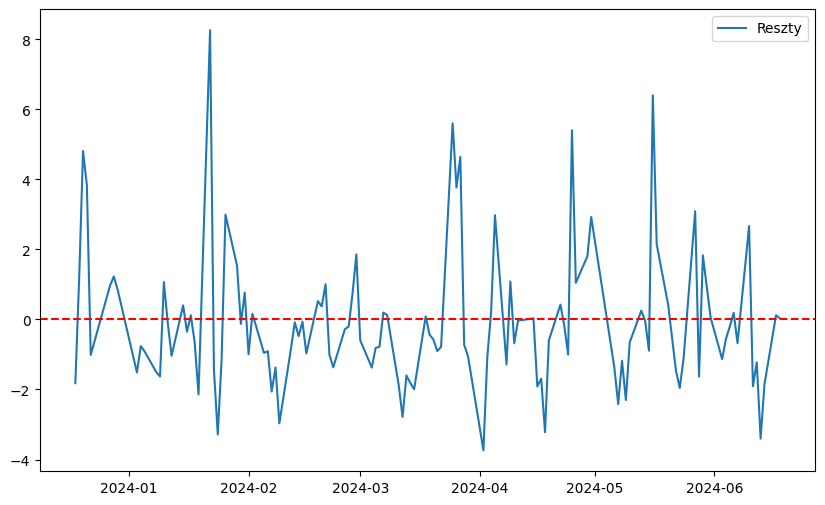

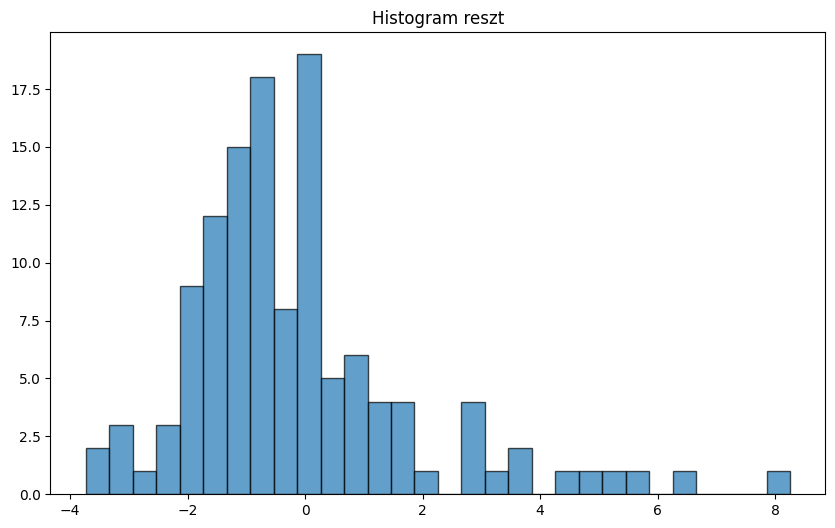

In [ ]:
import matplotlib.pyplot as plt

# Obliczenie reszt
residuals = np.exp(y_test) - 1 - forecast_original_scale

# Wykres reszt
plt.figure(figsize=(10, 6))
plt.plot(test['date'], residuals, label='Reszty')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.show()

# Histogram reszt
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram reszt')
plt.show()


### K-Fold Cross-Validation w szeregach czasowych

Kroswalidacja K-Fold jest techniką, która może dostarczyć bardziej wiarygodną ocenę modelu, dzieląc dane na kilka "foldów" (części), a następnie trenując i testując model na różnych kombinacjach tych części. Jednak w przypadku szeregów czasowych musimy zastosować wariant kroswalidacji, który zachowuje porządek czasowy danych, np. kroswalidacja rozszerzającego się okna czasowego.

**Implementacja kroswalidacji K-Fold dla szeregów czasowych:**
* Użyjemy funkcji TimeSeriesSplit z biblioteki scikit-learn, która jest specjalnie zaprojektowana do kroswalidacji w szeregach czasowych.

**Kroki:**
* Przygotowanie danych
* Definicja K-Fold Cross-Validation: Użycie TimeSeriesSplit.
* Ocena modelu za pomocą kroswalidacji: Przeprowadzenie kroswalidacji na modelu SARIMAX.

### Walidacja zmienna ilosc

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1619.041, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1579.747, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1617.084, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1614.508, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1574.227, Time=1.41 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1573.134, Time=2.33 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1573.798, Time=4.55 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1573.378, Time=5.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1571.534, Time=3.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1567.949, Time=1.46 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=1570.200, Time=2.77 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept

C:\Users\poczt\AppData\Local\Temp\ipykernel_16240\2681387295.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_scores, mae_scores, rmse_scores, mape_scores, r2_scores],


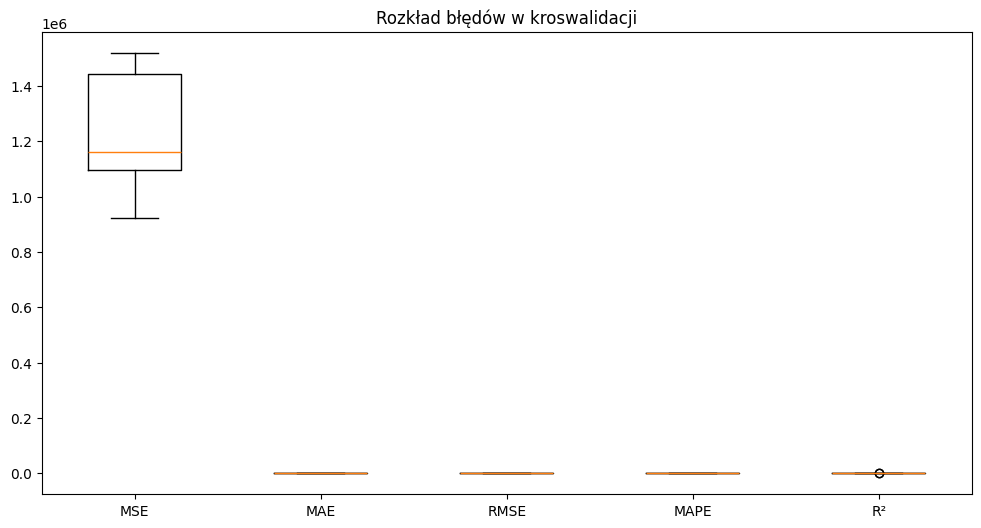

In [75]:
# Dane zależne
y = data['ilosc']

# Definicja TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Kroswalidacja
for i, (train_index, test_index) in enumerate(tscv.split(y), start=1):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Dopasowanie modelu auto_arima
    smodel = pm.auto_arima(y_train,
                           start_p=1, start_q=1,
                           max_p=5, max_q=5,
                           max_P=5, max_Q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    # Wyświetlenie najlepszych parametrów modelu
    print(f'Best model for fold {i}: order={smodel.order}, seasonal_order={smodel.seasonal_order}')
    
    # Prognozowanie na zestawie testowym
    forecast = smodel.predict(n_periods=len(y_test))
    
    # Obliczenie metryk
    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)
    rmse = mse ** 0.5
    mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
    r2 = r2_score(y_test, forecast)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Średnie metryki
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)
mean_r2 = np.mean(r2_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Mean MAE: {mean_mae}')
print(f'Mean RMSE: {mean_rmse}')
print(f'Mean MAPE: {mean_mape}%')
print(f'Mean R²: {mean_r2}')

# Dodatkowy kod do wizualizacji rozkładu błędów
plt.figure(figsize=(12, 6))
plt.boxplot([mse_scores, mae_scores, rmse_scores, mape_scores, r2_scores], 
            labels=['MSE', 'MAE', 'RMSE', 'MAPE', 'R²'])
plt.title('Rozkład błędów w kroswalidacji')
plt.show()


### Walidacja zmienna customers

In [76]:
# Dane zależne
y = data['customers']

# Definicja TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Kroswalidacja
for i, (train_index, test_index) in enumerate(tscv.split(y), start=1):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Dopasowanie modelu auto_arima
    smodel = pm.auto_arima(y_train,
                           start_p=1, start_q=1,
                           max_p=5, max_q=5,
                           max_P=5, max_Q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    # Wyświetlenie najlepszych parametrów modelu
    print(f'Best model for fold {i}: order={smodel.order}, seasonal_order={smodel.seasonal_order}')
    
    # Prognozowanie na zestawie testowym
    forecast = smodel.predict(n_periods=len(y_test))
    
    # Obliczenie metryk
    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)
    rmse = mse ** 0.5
    mape = np.mean(np.abs((y_test - forecast) / y_test)) * 100
    r2 = r2_score(y_test, forecast)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

# Średnie metryki
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)
mean_r2 = np.mean(r2_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Mean MAE: {mean_mae}')
print(f'Mean RMSE: {mean_rmse}')
print(f'Mean MAPE: {mean_mape}%')
print(f'Mean R²: {mean_r2}')

# Dodatkowy kod do wizualizacji rozkładu błędów
plt.figure(figsize=(12, 6))
plt.boxplot([mse_scores, mae_scores, rmse_scores, mape_scores, r2_scores], 
            labels=['MSE', 'MAE', 'RMSE', 'MAPE', 'R²'])
plt.title('Rozkład błędów w kroswalidacji')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=869.120, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=828.565, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=867.366, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=865.820, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=826.535, Time=1.10 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=826.371, Time=2.20 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=828.220, Time=3.70 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=825.084, Time=2.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=823.720, Time=0.86 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=824.278, T

KeyboardInterrupt: 

### Walidacja zmienna articles

In [77]:

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne
y = data['articles']

# Definicja TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []

# Kroswalidacja
for i, (train_index, test_index) in enumerate(tscv.split(y), start=1):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Dopasowanie modelu auto_arima
    smodel = pm.auto_arima(y_train,
                           start_p=1, start_q=1,
                           max_p=5, max_q=5,
                           max_P=5, max_Q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    # Wyświetlenie najlepszych parametrów modelu
    print(f'Best model for fold {i}: order={smodel.order}, seasonal_order={smodel.seasonal_order}')
    
    # Prognozowanie na zestawie testowym
    forecast = smodel.predict(n_periods=len(y_test))
    
    # Obliczenie metryk
    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)
    
    mse_scores.append(mse)
    mae_scores.append(mae)

# Średnie metryki
mean_mse = np.mean(mse_scores)
mean_mae = np.mean(mae_scores)

print(f'Mean MSE: {mean_mse}')
print(f'Mean MAE: {mean_mae}')


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1533.912, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1492.914, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1532.099, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1529.473, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1487.561, Time=0.79 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1485.923, Time=0.99 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1487.714, Time=1.60 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=1487.287, Time=2.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1485.252, Time=1.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1483.259, Time=0.64 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : 

## Trenowanie ostatecznego modelu z wybranymi parametrami

In [ ]:
# Dopasowanie najlepszego modelu do całego zestawu treningowego
final_model = pm.ARIMA(
    order=(1, 0, 0), 
    seasonal_order=(5, 1, 0, 12)
)

# Trenowanie modelu
final_model.fit(y_train)


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(order=(1, 0, 0), seasonal_order=(5, 1, 0, 12))

In [ ]:
# Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne na zestawie treningowym
y_train = train['ilosc']
y_test = test['ilosc']

In [ ]:
print(train.shape, test.shape)

(491, 23) (123, 23)


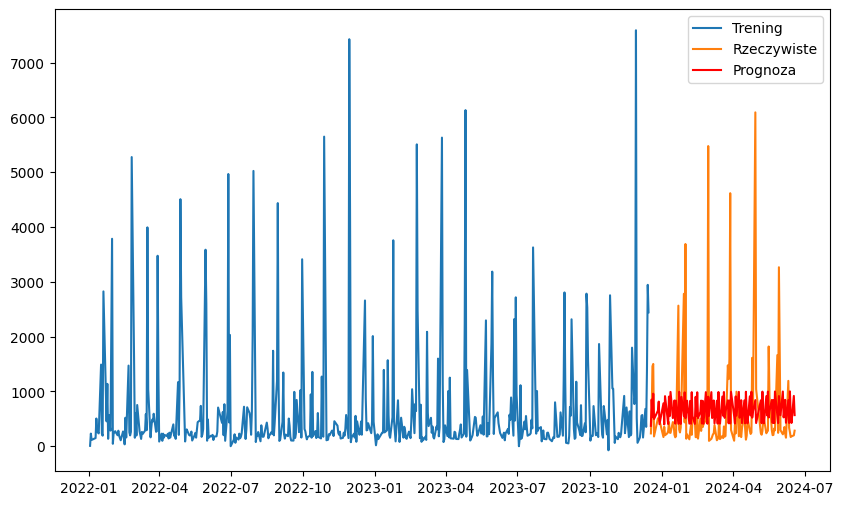

Mean Squared Error: 987780.8501201471
Mean Absolute Error: 598.6701527288333


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prognozowanie na zestawie testowym
forecast = smodel.predict(n_periods=len(y_test))

# Ocena modelu
plt.figure(figsize=(10, 6))
plt.plot(train['date'], y_train, label='Trening')
plt.plot(test['date'], y_test, label='Rzeczywiste')
plt.plot(test['date'], forecast, label='Prognoza', color='red')
plt.legend()
plt.show()

# Wyświetlenie metryk oceny
mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

## Kod do wykrywania wartości odstających i wyświetlania dat

### Dodanie zmiennej egozgenicznej koniec miesiąca

MSE without exogenous variables: 1442303.8480716571
MAE without exogenous variables: 746.3579049836549


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: exogenous. After release 0.14, this will raise.
  warnings.warn(


MSE with exogenous variables: 1442303.8480716571
MAE with exogenous variables: 746.3579049836549


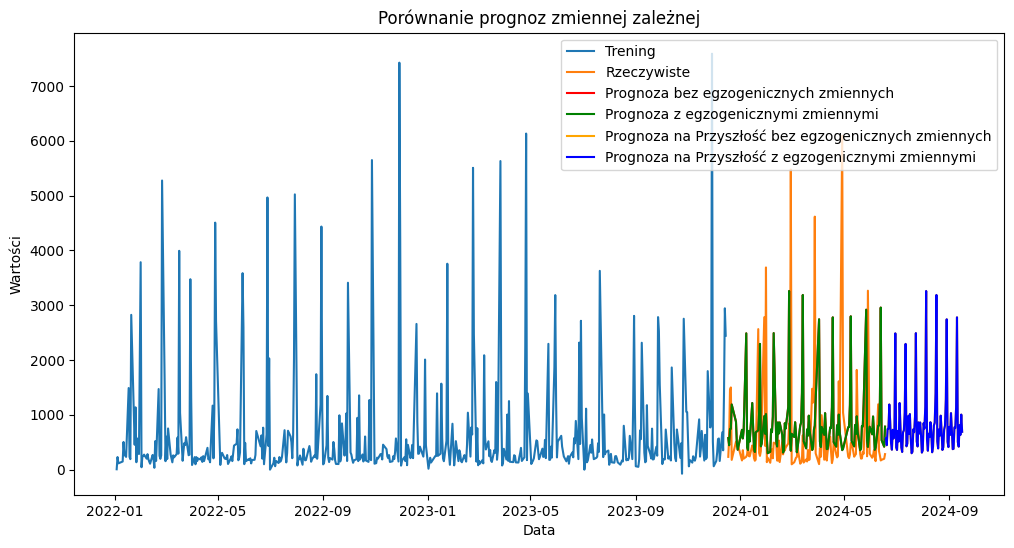

MSE without exogenous variables: 1442303.8480716571
MAE without exogenous variables: 746.3579049836549
MSE with exogenous variables: 1442303.8480716571
MAE with exogenous variables: 746.3579049836549


In [ ]:
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Adding columns for specific days
data['is_last_days'] = data['day'].isin([28, 29, 30]).astype(int)

# Adding flag for weak months
data['is_weak_month'] = data['month'].isin([6, 7, 8]).astype(int)

# Adding flag for Saturday
data['is_saturday'] = (data['date'].dt.weekday == 5).astype(int)

# Splitting data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dependent and exogenous variables
y_train = train['ilosc']
y_test = test['ilosc']
X_train = train[['is_last_days', 'is_weak_month', 'is_saturday', 'customers', 'articles', 'week_of_year', 'quarter', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'season_sin', 'season_cos']]
X_test = test[['is_last_days', 'is_weak_month', 'is_saturday', 'customers', 'articles', 'week_of_year', 'quarter', 'season', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'season_sin', 'season_cos']]

# Training ARIMA model without exogenous variables
model_without_exog = pm.ARIMA(
    order=(1, 0, 0), 
    seasonal_order=(5, 1, 0, 12)
)

# Training the model
model_without_exog.fit(y_train)

# Forecasting on the test set
forecast_without_exog = model_without_exog.predict(n_periods=len(y_test))

# Calculating metrics without exogenous variables
mse_without_exog = mean_squared_error(y_test, forecast_without_exog)
mae_without_exog = mean_absolute_error(y_test, forecast_without_exog)

print(f'MSE without exogenous variables: {mse_without_exog}')
print(f'MAE without exogenous variables: {mae_without_exog}')

# Training ARIMA model with exogenous variables
model_with_exog = pm.ARIMA(
    order=(1, 0, 0), 
    seasonal_order=(5, 1, 0, 12)
)

# Training the model with exogenous variables
model_with_exog.fit(y_train, exogenous=X_train)

# Forecasting on the test set with exogenous variables
forecast_with_exog = model_with_exog.predict(n_periods=len(y_test), exogenous=X_test)

# Calculating metrics with exogenous variables
mse_with_exog = mean_squared_error(y_test, forecast_with_exog)
mae_with_exog = mean_absolute_error(y_test, forecast_with_exog)

print(f'MSE with exogenous variables: {mse_with_exog}')
print(f'MAE with exogenous variables: {mae_with_exog}')

# Forecasting into the future (next 90 days)
forecast_periods = 90
last_date = data['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Future exogenous variables
future_data = pd.DataFrame({
    'date': future_dates,
    'day': future_dates.day,
    'month': future_dates.month
})
future_data['is_last_days'] = future_data['day'].isin([28, 29, 30]).astype(int)
future_data['is_weak_month'] = future_data['month'].isin([6, 7, 8]).astype(int)
future_data['is_saturday'] = (future_data['date'].dt.weekday == 5).astype(int)
future_exog = future_data[['is_last_days', 'is_weak_month', 'is_saturday']]

# Future forecast without exogenous variables
future_forecast_without_exog = model_without_exog.predict(n_periods=forecast_periods)

# Future forecast with exogenous variables
future_forecast_with_exog = model_with_exog.predict(n_periods=forecast_periods, exogenous=future_exog)

# Visualization of the results
plt.figure(figsize=(12, 6))

# Training line
plt.plot(train['date'], y_train, label='Trening')

# Actual line
plt.plot(test['date'], y_test, label='Rzeczywiste')

# Forecast on test set without exogenous variables
plt.plot(test['date'], forecast_without_exog, label='Prognoza bez egzogenicznych zmiennych', color='red')

# Forecast on test set with exogenous variables
plt.plot(test['date'], forecast_with_exog, label='Prognoza z egzogenicznymi zmiennymi', color='green')

# Future forecast without exogenous variables
plt.plot(future_dates, future_forecast_without_exog, label='Prognoza na Przyszłość bez egzogenicznych zmiennych', color='orange')

# Future forecast with exogenous variables
plt.plot(future_dates, future_forecast_with_exog, label='Prognoza na Przyszłość z egzogenicznymi zmiennymi', color='blue')

# Plot settings
plt.legend()
plt.xlabel('Data')
plt.ylabel('Wartości')
plt.title('Porównanie prognoz zmiennej zależnej')
plt.show()

print(f'MSE without exogenous variables: {mse_without_exog}')
print(f'MAE without exogenous variables: {mae_without_exog}')
print(f'MSE with exogenous variables: {mse_with_exog}')
print(f'MAE with exogenous variables: {mae_with_exog}')

## Model dla artykułów

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W', 'ArticleID']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())

# Wybierz 5 artykułów z najwyższą liczbą obserwacji
top_articles = data['articleid'].value_counts().nlargest(5).index

# Agregacja danych dziennych dla wybranych artykułów
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
aggregated_data = data[data['articleid'].isin(top_articles)].groupby(['articleid', pd.Grouper(freq='D')]).sum().reset_index()

# Logarytmizacja i standaryzacja zmiennej 'ilosc' dla każdego artykułu
article_models = {}
for article_id in aggregated_data['articleid'].unique():
    article_data = aggregated_data[aggregated_data['articleid'] == article_id].copy()
    
    # Sprawdzenie liczby obserwacji
    if len(article_data) < 8:  # Sprawdzenie, czy mamy wystarczająco dużo danych (8 tygodni)
        print(f'Article ID: {article_id} ma za mało danych do trenowania modelu.')
        continue

    # Sprawdzenie stacjonarności danych
    result = adfuller(article_data['ilosc'])
    if result[1] > 0.05:
        print(f'Article ID: {article_id} dane nie są stacjonarne, pomijamy.')
        continue
    
    # Logarytmizacja zmiennej 'ilosc'
    article_data['ilosc_log'] = np.log(article_data['ilosc'] + 1)

    # Standaryzacja zmiennej 'ilosc_log'
    scaler = StandardScaler()
    article_data['ilosc_log_std'] = scaler.fit_transform(article_data[['ilosc_log']])

    # Podział danych na zestaw treningowy i testowy
    train_size = int(len(article_data) * 0.8)
    train, test = article_data.iloc[:train_size], article_data.iloc[train_size:]

    # Dane zależne i zmienne egzogeniczne (jeśli istnieją)
    y_train = train['ilosc_log_std']
    y_test = test['ilosc_log_std']
    X_train = train[['articles']] if 'articles' in train.columns else None
    X_test = test[['articles']] if 'articles' in test.columns else None

    # Model ARIMA
    model = pm.ARIMA(
        order=(1, 0, 0),
        seasonal_order=(3, 0, 0, 365)  # Uproszczony model z sezonowością roczną
    )

    # Trenowanie modelu
    try:
        if X_train is not None:
            model.fit(y_train, exogenous=X_train)
        else:
            model.fit(y_train)
    except Exception as e:
        print(f'Nie udało się dopasować modelu dla Article ID: {article_id}. Błąd: {e}')
        continue

    # Prognozowanie na zestawie testowym
    if X_test is not None:
        forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
    else:
        forecast = model.predict(n_periods=len(y_test))

    # Odwrócenie standaryzacji i logarytmizacji prognoz
    forecast_original_scale = np.exp(scaler.inverse_transform(forecast.values.reshape(-1, 1))) - 1
    y_test_original_scale = np.exp(scaler.inverse_transform(y_test.values.reshape(-1, 1))) - 1

    # Obliczenie metryk na oryginalnej skali
    mse = mean_squared_error(y_test_original_scale, forecast_original_scale)
    mae = mean_absolute_error(y_test_original_scale, forecast_original_scale)

    # Obliczenie procentowej różnicy
    mean_sales = np.mean(article_data['ilosc'])
    normalized_mse = mse / mean_sales**2
    mae_percentage = (mae / mean_sales) * 100

    # Wyświetlenie wyników
    print(f'Article ID: {article_id}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'Normalized MSE: {normalized_mse}')
    print(f'MAE as percentage of mean sales: {mae_percentage}%')

    # Prognozowanie na przyszłość (kolejne 30 dni)
    forecast_periods = 30
    last_date = article_data['date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

    # Przykładowe dane dla zmiennej egzogenicznej 'articles' w przyszłości (jeśli istnieją)
    future_articles = np.random.randint(1, 100, size=forecast_periods) if 'articles' in article_data.columns else None
    future_articles_std = scaler.transform(future_articles.reshape(-1, 1)) if future_articles is not None else None

    # Prognozowanie na przyszłość
    if future_articles_std is not None:
        future_forecast = model.predict(n_periods=forecast_periods, exogenous=future_articles_std)
    else:
        future_forecast = model.predict(n_periods=forecast_periods)

    # Odwrócenie standaryzacji i logarytmizacji prognoz na przyszłość
    future_forecast_original_scale = np.exp(scaler.inverse_transform(future_forecast.values.reshape(-1, 1))) - 1

    # Zapisanie modelu i wyników dla artykułu
    article_models[article_id] = {
        'model': model,
        'scaler': scaler,
        'train': train,
        'test': test,
        'forecast': forecast_original_scale,
        'y_test': y_test_original_scale,
        'future_forecast': future_forecast_original_scale,
        'future_dates': future_dates
    }

    # Wizualizacja wyników
    plt.figure(figsize=(12, 6))

    # Linia treningowa
    plt.plot(train['date'], train['ilosc'], label='Trening (oryginalne dane)')

    # Linia rzeczywista
    plt.plot(test['date'], test['ilosc'], label='Rzeczywiste (oryginalne dane)')

    # Linia prognozy na zestawie testowym
    plt.plot(test['date'], forecast_original_scale, label='Prognoza', color='red')

    # Linia prognozy na przyszłość
    plt.plot(future_dates, future_forecast_original_scale, label='Prognoza na przyszłość', color='green')

    # Ustawienia wykresu
    plt.legend()
    plt.xlabel('Data')
    plt.ylabel('Wartości')
    plt.title(f'Prognozy zmiennej zależnej (artykuł ID: {article_id})')
    plt.show()


        date  articleid  ilosc  articles  customers
0 2022-01-03      12395  2.210         1          1
1 2022-01-03      12407  2.210         2          1
2 2022-01-03      12431  2.210         2          1
3 2022-01-03      26101  0.221         1          1
4 2022-01-03      43356  0.221         1          1


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: exogenous. After release 0.14, this will raise.
  warnings.warn(


# Model oparty o regresje klientów w celu lepszych predykcji do przodu

## Customers

In [7]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne i zmienne egzogeniczne
y_train = train['customers']
y_test = test['customers']


# Trenowanie modelu ARIMA bez egzogenicznych zmiennych
model_customers = pm.ARIMA(
    order=(1, 0, 0), 
    seasonal_order=(5, 1, 0, 12)
)

# Trenowanie modelu
model_customers.fit(y_train)

# Prognozowanie na zestawie testowym
forecast_customers = model_customers.predict(n_periods=len(y_test))

# Prognozowanie na przyszłość (kolejne 90 dni)
forecast_periods = 44
last_date = data['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods)

# Prognoza na przyszłość bez egzogenicznych zmiennych
future_forecast_customers = model_customers.predict(n_periods=forecast_periods)

In [8]:
# print model statistics 
print(model_customers.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  491
Model:             SARIMAX(1, 0, 0)x(5, 1, 0, 12)   Log Likelihood               -2048.468
Date:                            Mon, 24 Jun 2024   AIC                           4112.936
Time:                                    11:30:51   BIC                           4146.310
Sample:                                         0   HQIC                          4126.056
                                            - 491                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4423      0.950      1.518      0.129      -0.420       3.305
ar.L1         -0.1323      0.035   

In [9]:
future_customers = future_forecast_customers
# change type to np.array
future_customers = np.array(future_customers)

## Articles

In [10]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne i zmienne egzogeniczne
y_train = train['articles']
y_test = test['articles']


# Trenowanie modelu ARIMA bez egzogenicznych zmiennych
model_articles = pm.ARIMA(
    order=(1, 0, 0), 
    seasonal_order=(5, 1, 0, 12)
)

# Trenowanie modelu
model_articles.fit(y_train)

# Prognozowanie na zestawie testowym
forecast_articles = model_articles.predict(n_periods=len(y_test))

# Prognozowanie na przyszłość (kolejne 90 dni)
forecast_periods = 44
last_date = data['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_periods)

# Prognoza na przyszłość bez egzogenicznych zmiennych
future_forecast_articles = model_articles.predict(n_periods=forecast_periods)

In [11]:
# get model statistics
print(model_articles.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  491
Model:             SARIMAX(1, 0, 0)x(5, 1, 0, 12)   Log Likelihood               -3819.676
Date:                            Mon, 24 Jun 2024   AIC                           7655.351
Time:                                    11:31:34   BIC                           7688.725
Sample:                                         0   HQIC                          7668.471
                                            - 491                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0252     53.522      0.243      0.808     -91.876     117.926
ar.L1          0.2134      0.041   

In [12]:
future_articles = future_forecast_articles
# change type to np.array
future_articles = future_articles.to_numpy()


In [84]:
# Creating DataFrame for future forecast
future_forecast_df = pd.DataFrame({'date': future_dates, 'customers': future_forecast_customers, 'articles': future_forecast_articles})
future_forecast_df.head()

date  customers     articles
491 2024-06-19  67.104030   736.339989
492 2024-06-20  57.999913   751.449178
493 2024-06-21  60.851546   918.746966
494 2024-06-22  70.028885   936.652697
495 2024-06-23  71.501352  1407.245109

## Regresja wieloraka

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.69e-300
Time:                        06:34:10   Log-Likelihood:                -4433.3
No. Observations:                 614   AIC:                             8873.
Df Residuals:                     611   BIC:                             8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.3499     52.696      3.688      0.0

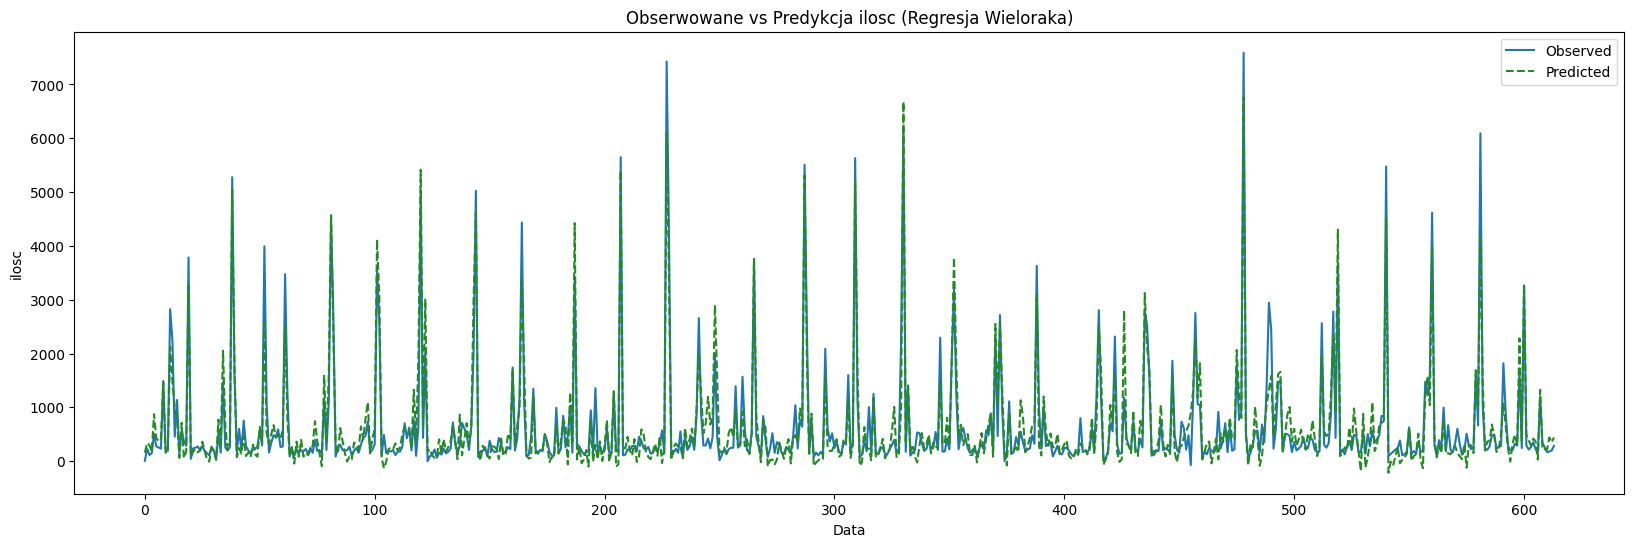

In [9]:
# Definicja zmiennych niezależnych i zależnych
X = data[[ 'articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje
data['predicted'] = model_multi.predict(X)

# Wykres
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--', color = 'forestgreen')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.69e-300
Time:                        06:48:05   Log-Likelihood:                -4433.3
No. Observations:                 614   AIC:                             8873.
Df Residuals:                     611   BIC:                             8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.3499     52.696      3.688      0.0

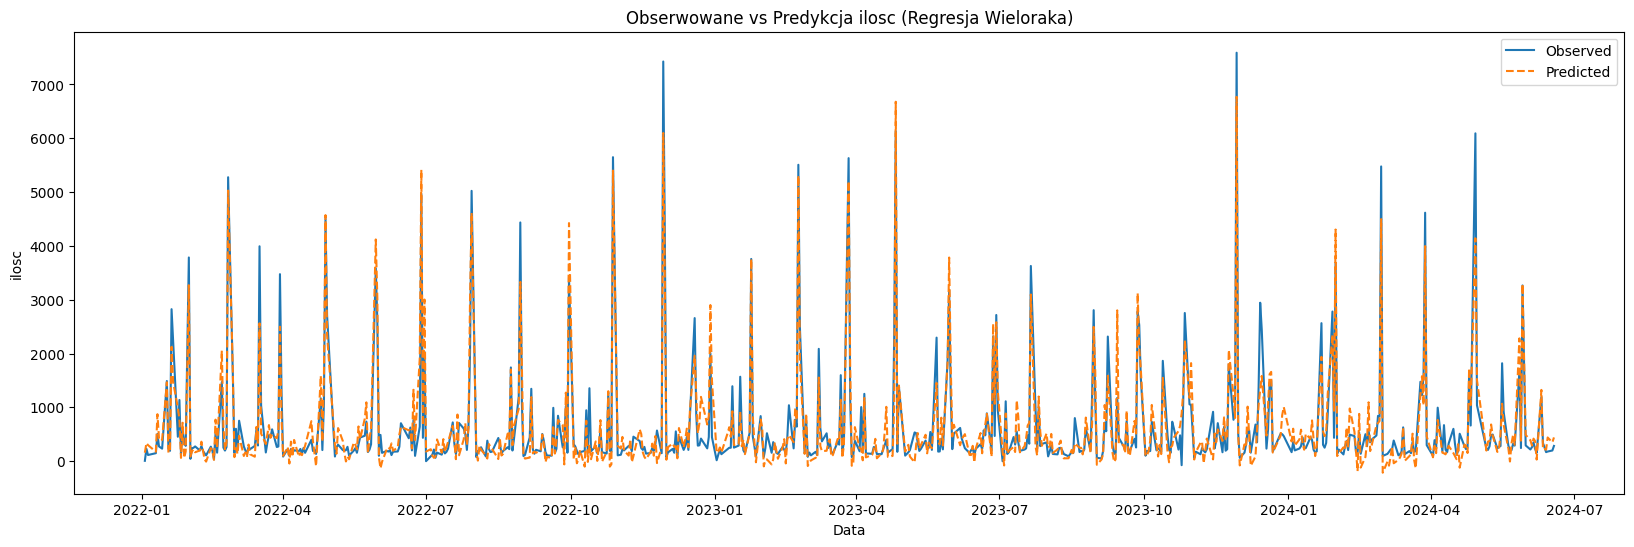

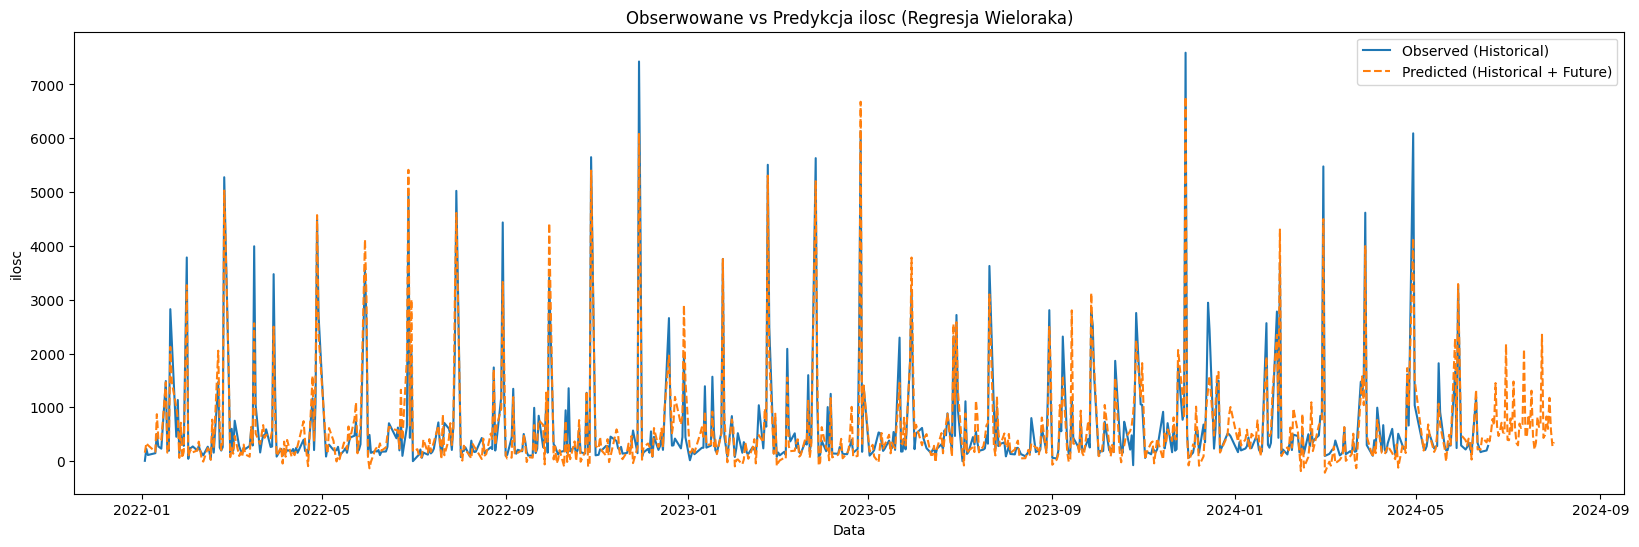

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'data' is already defined and contains the historical data

# Ensure 'DATA_W' is datetime and set as index if not already done
if not pd.api.types.is_datetime64_any_dtype(data['date']):
    data['date'] = pd.to_datetime(data['date'])

data.set_index('date', inplace=True)

# Definicja zmiennych niezależnych i zależnych
X = data[['articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na podstawie danych historycznych
data['predicted'] = model_multi.predict(X)

# Wykres danych historycznych i predykcji
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

# Prognozowanie na przyszłość (44 dni)
# Replace future_forecast_articles and future_forecast_customers with your actual future data
future_articles = future_forecast_articles.to_numpy()
future_customers = future_forecast_customers.to_numpy()

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Adding a constant (intercept) to future data
future_exogenous = np.column_stack([np.ones(future_articles.shape[0]), future_articles, future_customers])

# Predicting future values
future_predicted = model_multi.predict(future_exogenous)

# Create a dataframe for future dates
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')
future_df = pd.DataFrame({'articles': future_articles, 'customers': future_customers, 'predicted': future_predicted}, index=future_dates)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], future_df])

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  ilosc   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     2616.
Date:                Mon, 24 Jun 2024   Prob (F-statistic):          2.69e-300
Time:                        07:45:19   Log-Likelihood:                -4433.3
No. Observations:                 614   AIC:                             8873.
Df Residuals:                     611   BIC:                             8886.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        194.3499     52.696      3.688      0.0

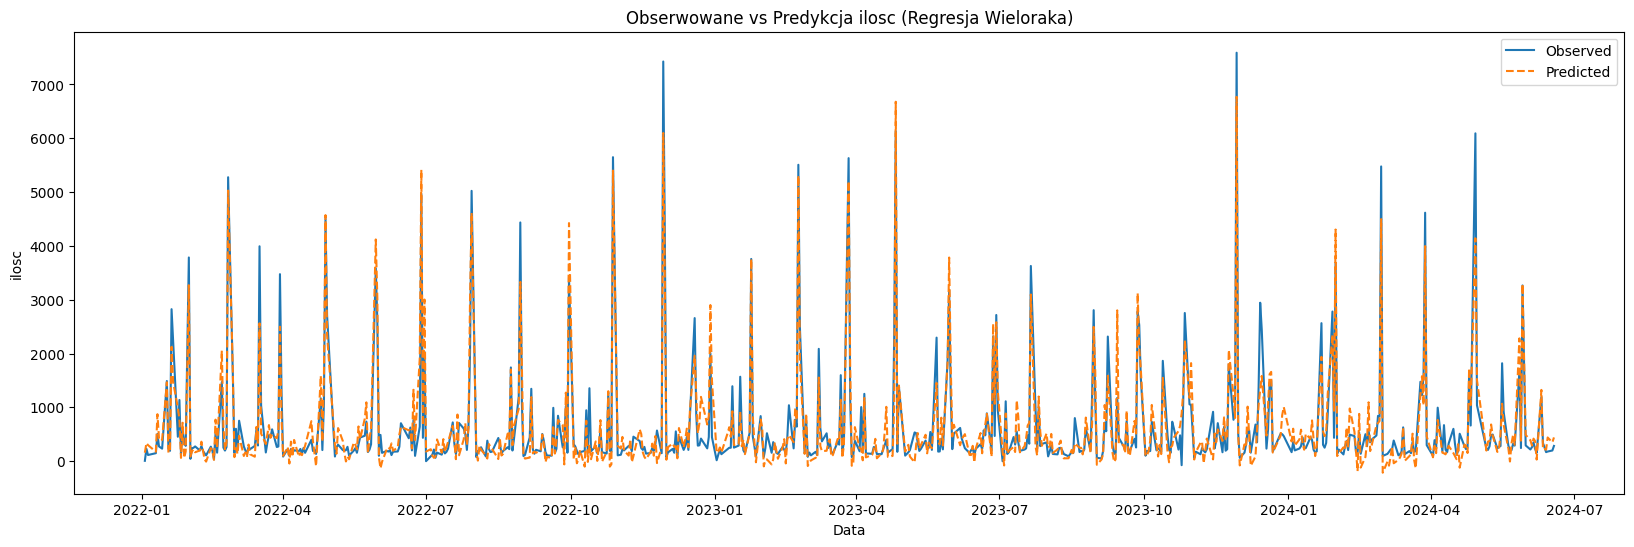

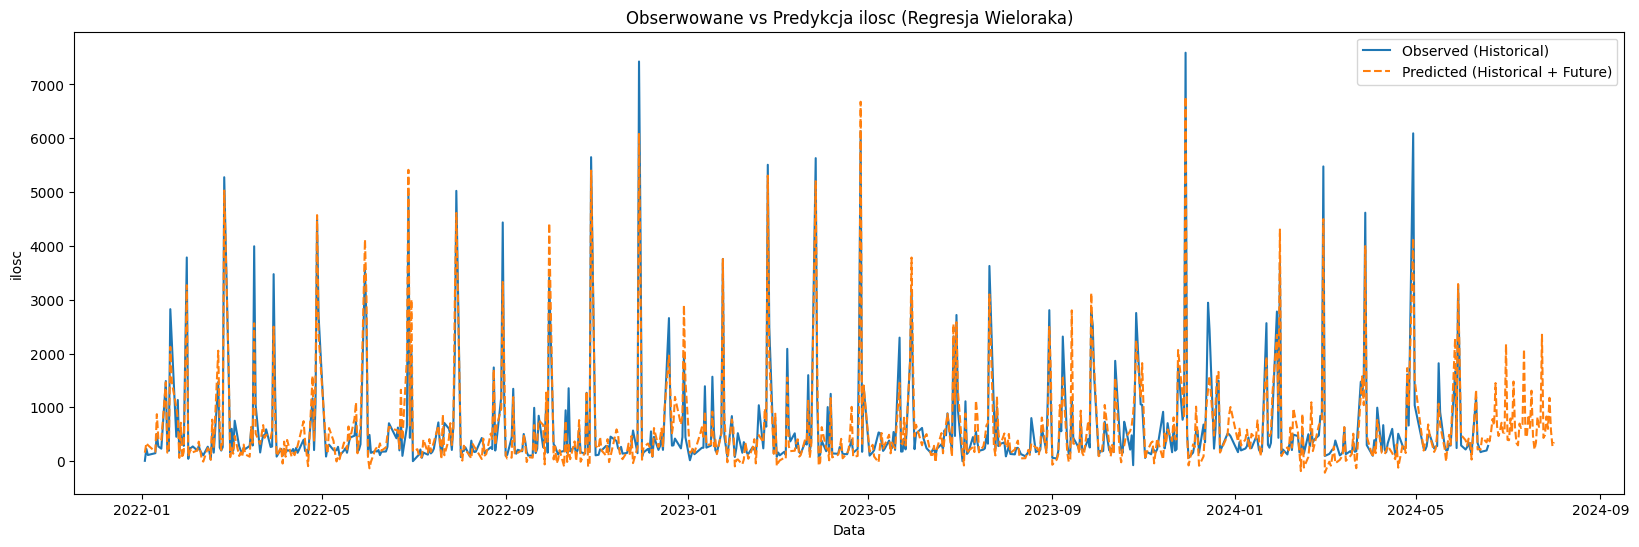

In [24]:
# Definicja zmiennych niezależnych i zależnych
X = data[['articles', 'customers']]
y = data['ilosc']

# Dodanie stałej do modelu (intercept)
X = sm.add_constant(X)

# Dopasowanie modelu regresji wielorakiej
model_multi = sm.OLS(y, X).fit()

# Podsumowanie modelu
summary_multi = model_multi.summary()
print(summary_multi)

# Predykcje na podstawie danych historycznych
data['predicted'] = model_multi.predict(X)

# Wykres danych historycznych i predykcji
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

# Prognozowanie na przyszłość (44 dni)
# Replace future_forecast_articles and future_forecast_customers with your actual future data
future_articles = future_forecast_articles.to_numpy()
future_customers = future_forecast_customers.to_numpy()

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Adding a constant (intercept) to future data
future_exogenous = np.column_stack([np.ones(future_articles.shape[0]), future_articles, future_customers])

# Predicting future values
future_predicted = model_multi.predict(future_exogenous)

# Create a dataframe for future dates
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')
future_df = pd.DataFrame({'articles': future_articles, 'customers': future_customers, 'predicted': future_predicted}, index=future_dates)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], future_df])

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data.index,
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data.index > last_date, '')
})

# Save the dataframe to a CSV file
final_df.to_csv('prediction_results_reg.csv', index=False)

# Display the final dataframe for confirmation
##import ace_tools as tools; tools.display_dataframe_to_user(name="Prediction Results", dataframe=final_df)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (Regresja Wieloraka)')
plt.legend()
plt.show()

In [87]:
# Adding missing columns to data
for column in future_forecast_df.columns:
    if column not in data.columns:
        data[column] = np.nan

# Adding missing columns to future_forecast_df
for column in data.columns:
    if column not in future_forecast_df.columns:
        future_forecast_df[column] = np.nan

# Align the column order
df1 = data[future_forecast_df.columns]

# Concatenate the DataFrames
data = pd.concat([data, future_forecast_df], ignore_index=True)

# Display the result
data.tail(100)

date     ilosc     articles  customers  year  month  day  \
558 2024-03-26  1224.782  1590.000000  83.000000  2024      3   26   
559 2024-03-27  1589.211  1098.000000  64.000000  2024      3   27   
560 2024-03-28  4616.911  2909.000000  74.000000  2024      3   28   
561 2024-03-29   297.908  1063.000000  96.000000  2024      3   29   
562 2024-04-02   100.997   374.000000  47.000000  2024      4    2   
..         ...       ...          ...        ...   ...    ...  ...   
653 2024-07-28       NaN   904.252430  70.592125  2024      7   28   
654 2024-07-29       NaN  1321.632729  79.282216  2024      7   29   
655 2024-07-30       NaN   706.145104  51.353004  2024      7   30   
656 2024-07-31       NaN   708.900696  69.703386  2024      7   31   
657 2024-08-01       NaN   611.695153  54.969956  2024      8    1   

     day_of_year  week_of_year  quarter  ...  articles_seasonal  \
558           86            13        1  ...         171.774581   
559           87            13        1  ...         213.432869   
560           88            13        1  ...         478.933304   
561           89            13        1  ...          82.154092   
562           93            14        2  ...        -262.335312   
..           ...           ...      ...  ...                ...   
653          210            30        3  ...                NaN   
654          211            31        3  ...                NaN   
655          212            31        3  ...                NaN   
656          213            31        3  ...                NaN   
657          214            31        3  ...                NaN   

     articles_resid  customers_trend  customers_seasonal  customers_resid  \
558      559.427342        66.471154            2.960679        13.568167   
559       24.028669        66.480769            6.933793        -9.414562   
560     1570.595542        66.605769           -6.262163        13.656394   
561      123.326677        66.471154            6.230182        23.298665   
562     -221.645458        66.423077           -7.098507       -12.324570   
..              ...              ...                 ...              ...   
653             NaN              NaN                 NaN              NaN   
654             NaN              NaN                 NaN              NaN   
655             NaN              NaN                 NaN              NaN   
656             NaN              NaN                 NaN              NaN   
657             NaN              NaN                 NaN              NaN   

     period    predicted  ilosc_imputacja  ilosc_log  ilosc_log_std  
558     3.0  1578.814984      1224.782000   7.111334       1.235088  
559     3.0  1041.471657      1589.211000   7.371622       1.486631  
560     3.0  3996.434703       638.307425   8.437698       2.516891  
561     3.0   459.566608       297.908000   5.700136      -0.128699  
562     4.0    72.093786       100.997000   4.624943      -1.167769  
..      ...          ...              ...        ...            ...  
653     NaN          NaN              NaN        NaN            NaN  
654     NaN          NaN              NaN        NaN            NaN  
655     NaN          NaN              NaN        NaN            NaN  
656     NaN          NaN              NaN        NaN            NaN  
657     NaN          NaN              NaN        NaN            NaN  

[100 rows x 37 columns]

## Prognoza i test

In [88]:
# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Wyświetl pierwsze kilka wierszy przetworzonych danych
data.head(10)

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Wyświetl pierwsze kilka wierszy przetworzonych danych
print(data.head())

data.describe()

        date    ilosc  articles  customers
0 2022-01-03    7.072         7          3
1 2022-01-04  230.061       415         35
2 2022-01-05  115.141       411         37
3 2022-01-10  148.733       434         47
4 2022-01-11  505.648       896         53


date        ilosc     articles   customers
count                            614   614.000000   614.000000  614.000000
mean   2023-03-24 21:36:56.286644992   638.307425   823.167752   59.705212
min              2022-01-03 00:00:00   -74.035000     1.000000    1.000000
25%              2022-08-13 00:00:00   181.441000   488.500000   52.000000
50%              2023-03-22 12:00:00   259.233000   636.500000   59.000000
75%              2023-11-01 12:00:00   556.146500   862.750000   67.000000
max              2024-06-18 00:00:00  7589.803000  4577.000000  124.000000
std                              NaN  1023.765432   634.598299   16.194356

In [ ]:
import numpy as np
import pandas as pd
from pmdarima import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt



# Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne
y_train = train['ilosc']
y_test = test['ilosc']

# Dane egzogeniczne
X_train = train[['articles', 'customers']]
X_test = test[['articles', 'customers']]

# Najlepsze parametry modelu
order = (1, 0, 0)
seasonal_order = (5, 1, 0, 12)

# Dopasowanie modelu ARIMA z wybranymi parametrami
model = ARIMA(order=order, seasonal_order=seasonal_order)
model.fit(y_train, exogenous=X_train)

# Prognozowanie na zestawie testowym z zmiennymi egzogenicznymi
forecast_exo = model.predict(n_periods=len(y_test), exogenous=X_test)

# Prognozowanie na przyszłość (44 dni)
future_exogenous = np.column_stack([future_articles, future_customers])
future_forecast = model.predict(n_periods=44, exogenous=future_exogenous)

# Łączenie prognoz i rzeczywistych wartości dla wizualizacji
all_dates = np.concatenate([train['date'], test['date'], pd.date_range(start=test['date'].iloc[-1], periods=45, freq='D')[1:]])
all_values = np.concatenate([y_train, y_test, future_forecast])

# Wyświetlenie wykresu prognozy vs rzeczywiste wartości
plt.figure(figsize=(12, 8))
plt.plot(train['date'], y_train, label='Trening')
plt.plot(test['date'], y_test, label='Rzeczywiste')
plt.plot(test['date'], forecast_exo, label='Prognoza na zestawie testowym', color='orange')
plt.plot(pd.date_range(start=test['date'].iloc[-1], periods=45, freq='D')[1:], future_forecast, label='Prognoza na przyszłość', color='red')
plt.legend()
plt.show()

# Wyświetlenie metryk na zestawie testowym
test_mse = mean_squared_error(y_test, forecast_exo)
test_mae = mean_absolute_error(y_test, forecast_exo)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')



c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: exogenous. After release 0.14, this will raise.
  warnings.warn(


          date   actual  test    forecast
0   2022-01-03    7.072   NaN         NaN
1   2022-01-04  230.061   NaN         NaN
2   2022-01-05  115.141   NaN         NaN
3   2022-01-10  148.733   NaN         NaN
4   2022-01-11  505.648   NaN         NaN
..         ...      ...   ...         ...
653 2024-07-28      NaN   NaN  660.475075
654 2024-07-29      NaN   NaN  861.061933
655 2024-07-30      NaN   NaN  634.316577
656 2024-07-31      NaN   NaN  311.181254
657 2024-08-01      NaN   NaN  352.226357

[658 rows x 4 columns]


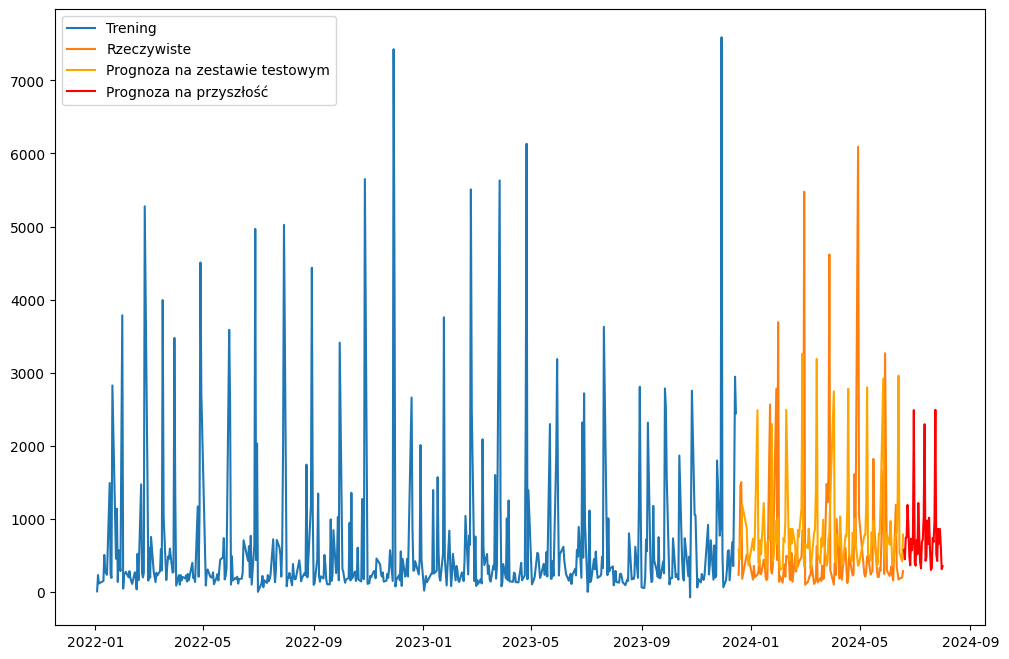

Test MSE: 1442303.8480716571
Test MAE: 746.3579049836549


In [ ]:
import numpy as np
import pandas as pd
from pmdarima import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# Podział danych na zestaw treningowy i testowy
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Dane zależne
y_train = train['ilosc']
y_test = test['ilosc']

# Dane egzogeniczne
X_train = train[['articles', 'customers']]
X_test = test[['articles', 'customers']]

# Najlepsze parametry modelu
order = (1, 0, 0)
seasonal_order = (5, 1, 0, 12)

# Dopasowanie modelu ARIMA z wybranymi parametrami
model = ARIMA(order=order, seasonal_order=seasonal_order)
model.fit(y_train, exogenous=X_train)

# Prognozowanie na zestawie testowym z zmiennymi egzogenicznymi
forecast_exo = model.predict(n_periods=len(y_test), exogenous=X_test)

# Prognozowanie na przyszłość (44 dni)
future_exogenous = np.column_stack([future_articles, future_customers])
future_forecast = model.predict(n_periods=44, exogenous=future_exogenous)

# Łączenie prognoz i rzeczywistych wartości dla wizualizacji
forecast_dates = pd.date_range(start=test['date'].iloc[-1], periods=45, freq='D')[1:]
all_dates = np.concatenate([train['date'], test['date'], forecast_dates])
all_values = np.concatenate([y_train, y_test, future_forecast])

# Tworzenie tabelki z datami, rzeczywistymi wartościami, wartościami testowymi i prognozami
df_results = pd.DataFrame({
    'date': all_dates,
    'actual': np.concatenate([y_train, y_test, [np.nan] * 44]),
    'test': np.concatenate([[np.nan] * len(y_train), y_test, [np.nan] * 44]),
    'forecast': np.concatenate([[np.nan] * (len(y_train) + len(y_test)), future_forecast])
})

# Wyświetlenie tabelki
print(df_results)

# Zapisanie tabelki do pliku CSV (opcjonalnie)
# df_results.to_csv('forecast_results.csv', index=False)

# Wyświetlenie wykresu prognozy vs rzeczywiste wartości
plt.figure(figsize=(12, 8))
plt.plot(train['date'], y_train, label='Trening')
plt.plot(test['date'], y_test, label='Rzeczywiste')
plt.plot(test['date'], forecast_exo, label='Prognoza na zestawie testowym', color='orange')
plt.plot(forecast_dates, future_forecast, label='Prognoza na przyszłość', color='red')
plt.legend()
plt.show()

# Wyświetlenie metryk na zestawie testowym
test_mse = mean_squared_error(y_test, forecast_exo)
test_mae = mean_absolute_error(y_test, forecast_exo)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')


In [ ]:
df_results.to_csv('forecast_results.csv', index=False)

## XGBoost

MSE: 83640.29414769387
MAE: 172.15572721453415


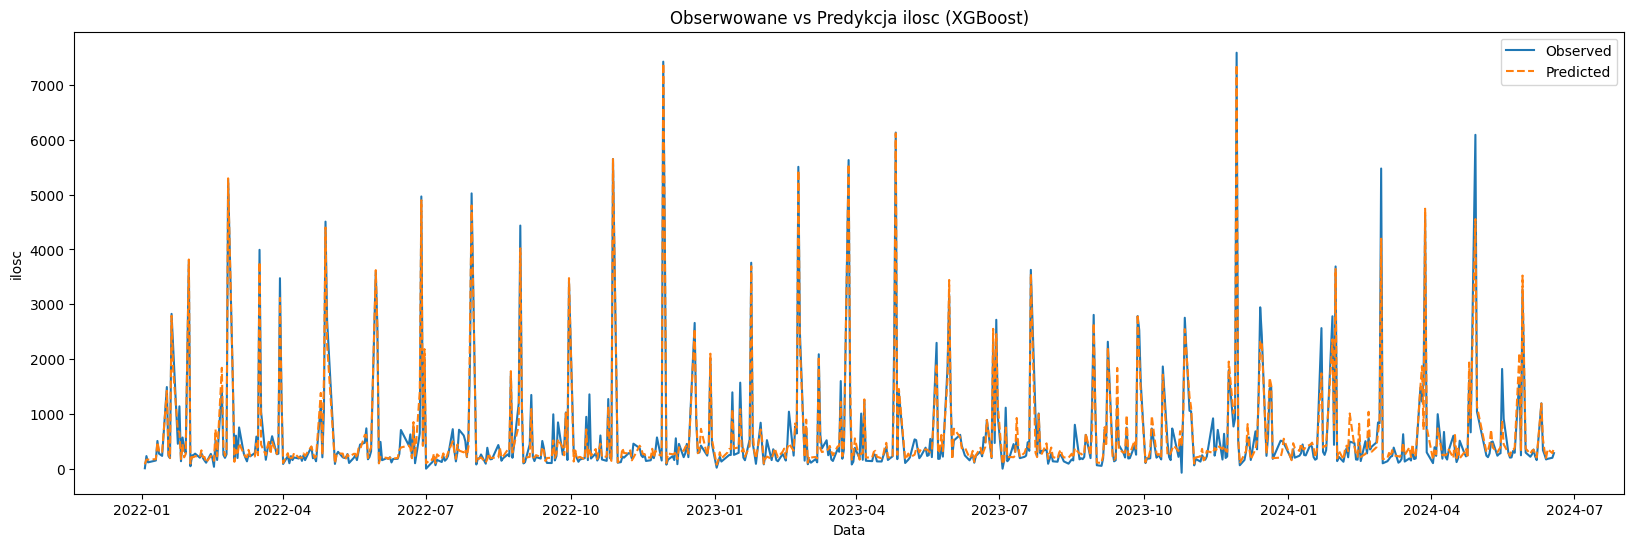

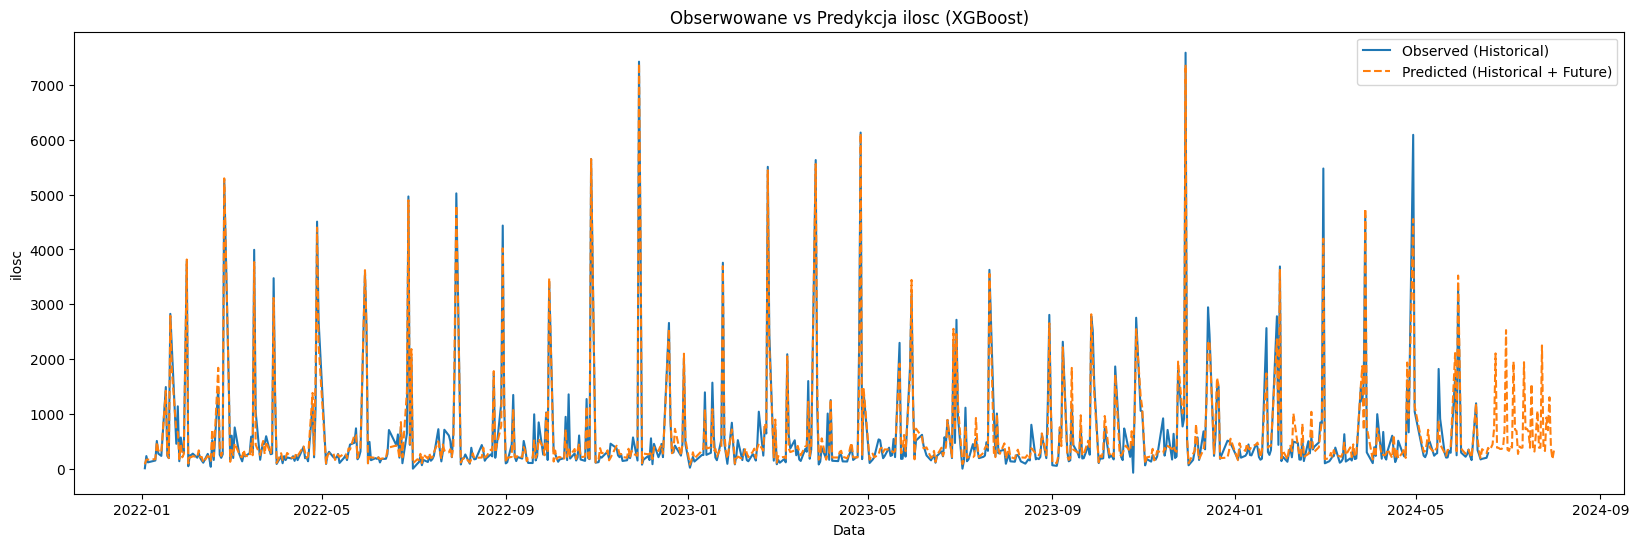

In [14]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Utworzenie cech czasowych
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter

# Tworzenie cechy sinusoidalnej dla sezonowości miesięcznej
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Podział danych na cechy (X) i zmienną docelową (y)
X = data.drop(columns=['date', 'ilosc'])
y = data['ilosc']

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Trenowanie modelu XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prognozowanie na zestawie testowym
y_pred = model.predict(X_test)

# Obliczenie metryk na zestawie testowym
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Ensure 'date' is datetime and set as index if not already done
data.set_index('date', inplace=True)

# Historical predictions using XGBoost
data['predicted'] = model.predict(X)

# Plotting historical data and predictions
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()

# Future prediction for 44 days
# Assuming future_forecast_articles and future_forecast_customers are provided
future_articles = future_forecast_articles.to_numpy()
future_customers = future_forecast_customers.to_numpy()

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Creating future DataFrame
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')

future_data = pd.DataFrame({
    'articles': future_articles,
    'customers': future_customers,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'day_of_week': future_dates.dayofweek,
    'week_of_year': future_dates.isocalendar().week,
    'quarter': future_dates.quarter,
    'month_sin': np.sin(2 * np.pi * future_dates.month / 12),
    'month_cos': np.cos(2 * np.pi * future_dates.month / 12)
}, index=future_dates)

# Future prediction
future_predicted = model.predict(future_data)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], pd.DataFrame({'predicted': future_predicted}, index=future_dates)], axis=0)

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data.index,
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data.index > last_date, '')
})

# Save the dataframe to a CSV file
##final_df.to_csv('prediction_results_xgb.csv', index=False)

# Display the final dataframe for confirmation
#import ace_tools as tools; tools.display_dataframe_to_user(name="Prediction Results", dataframe=final_df)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()


In [22]:
# Predict and calculate statistics
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Manually calculate R^2 score
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
ss_residual = np.sum((y_test - y_pred) ** 2)
r2 = 1 - (ss_residual / ss_total)

# Get model parameters
params = model.get_params()
params = {k: ('None' if v is None else v) for k, v in params.items()}
params = {k: ('nan' if isinstance(v, float) and np.isnan(v) else v) for k, v in params.items()}
df_params = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])

# Create a DataFrame for additional statistics
stats_data = {
    "Statistic": ["Mean Absolute Error", "Mean Squared Error", "Root Mean Squared Error", "R^2 Score"],
    "Value": [mae, mse, rmse, r2]
}
df_stats = pd.DataFrame(stats_data)

# # Write to Excel
# excel_path = "main_stats_xgb.xlsx"
# with pd.ExcelWriter(excel_path) as writer:
#     df_params.to_excel(writer, sheet_name='Parameters', index=False)
#     df_stats.to_excel(writer, sheet_name='Statistics', index=False)

# print(f"Model statistics have been written to {excel_path}")

In [25]:
# Predict and calculate statistics
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Manually calculate R^2 score
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
ss_residual = np.sum((y_test - y_pred) ** 2)
r2 = 1 - (ss_residual / ss_total)

# Get model parameters
params = model.get_params()
params = {k: ('None' if v is None else v) for k, v in params.items()}
params = {k: ('nan' if isinstance(v, float) and np.isnan(v) else v) for k, v in params.items()}

# Create DataFrame for parameters
df_params = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])

# Create a DataFrame for additional statistics
stats_data = {
    "Parameter": ["Mean Absolute Error", "Mean Squared Error", "Root Mean Squared Error", "R^2 Score"],
    "Value": [mae, mse, rmse, r2]
}
df_stats = pd.DataFrame(stats_data)

# Concatenate the DataFrames
df_combined = pd.concat([df_params, df_stats], ignore_index=True)

# Write to Excel
excel_path = "predictions_results_statistics_xgb.xlsx"
df_combined.to_excel(excel_path, index=False)

print(f"Model statistics have been written to {excel_path}")

Model statistics have been written to predictions_results_statistics_xgb.xlsx


In [21]:
# Predict and calculate statistics
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [19]:
# print XGBRegressor model statistics
#print(model.get_params())


# Get model parameters
params = model.get_params()

# Replace None and np.nan with string 'None' to make it display-friendly
params = {k: ('None' if v is None else v) for k, v in params.items()}
params = {k: ('nan' if isinstance(v, float) and np.isnan(v) else v) for k, v in params.items()}

# Convert to DataFrame
df_params = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])

# Display the DataFrame
print(df_params)

                  Parameter             Value
0                 objective  reg:squarederror
1                base_score              None
2                   booster              None
3                 callbacks              None
4         colsample_bylevel              None
5          colsample_bynode              None
6          colsample_bytree              None
7                    device              None
8     early_stopping_rounds              None
9        enable_categorical             False
10              eval_metric              None
11            feature_types              None
12                    gamma              None
13              grow_policy              None
14          importance_type              None
15  interaction_constraints              None
16            learning_rate               0.1
17                  max_bin              None
18        max_cat_threshold              None
19        max_cat_to_onehot              None
20           max_delta_step       

MSE: 83640.29414769387
MAE: 172.15572721453415
MAE as Percentage of Mean ILOSC: 26.97%


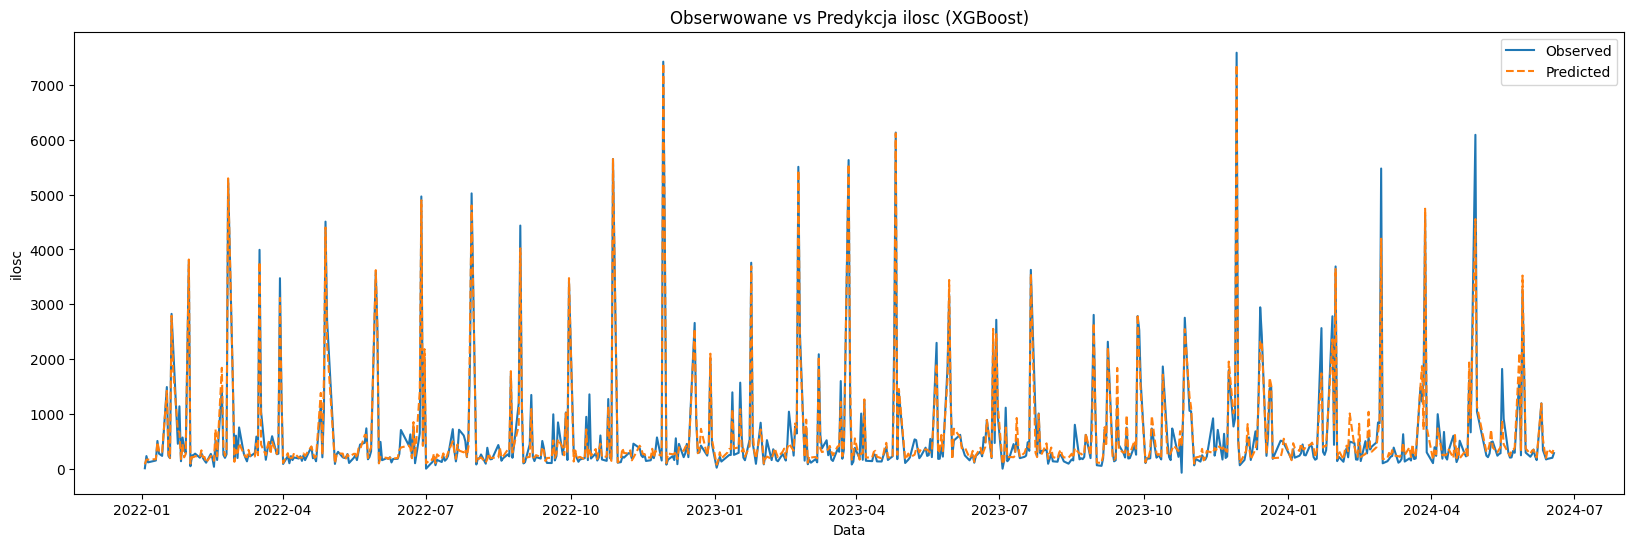

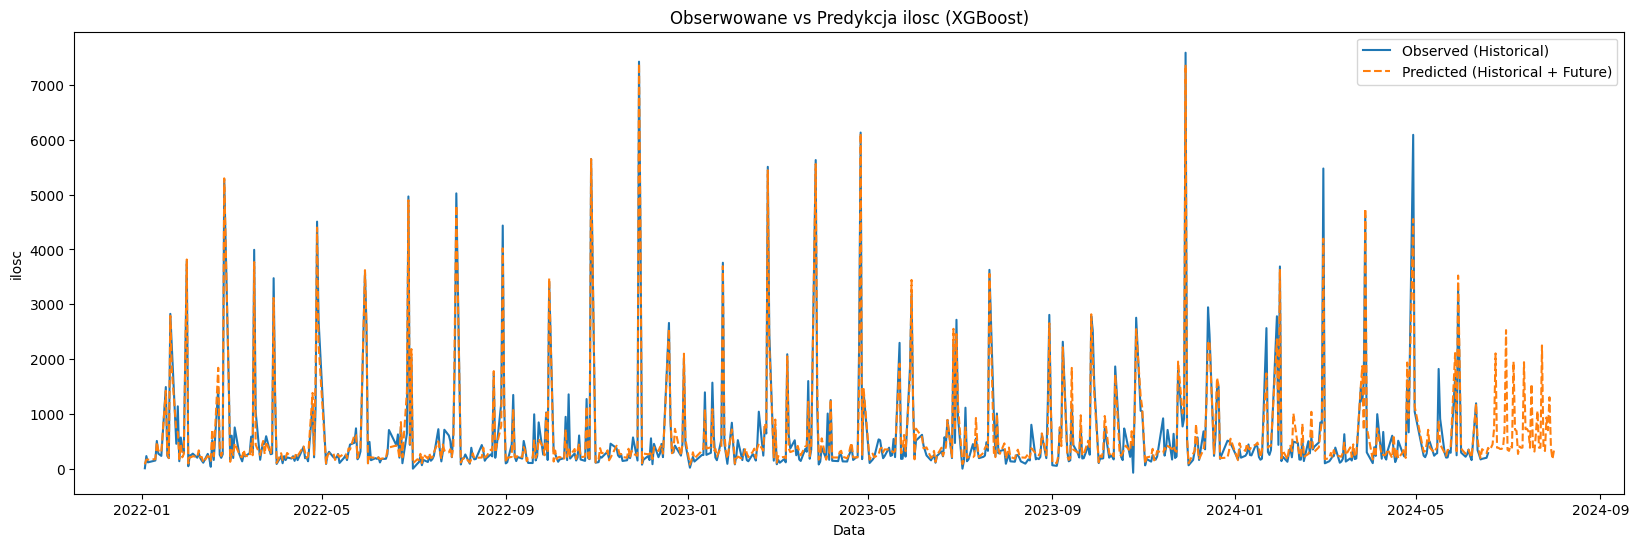

In [23]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Wczytaj dane z pliku CSV
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Utworzenie cech czasowych
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter

# Tworzenie cechy sinusoidalnej dla sezonowości miesięcznej
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Podział danych na cechy (X) i zmienną docelową (y)
X = data.drop(columns=['date', 'ilosc'])
y = data['ilosc']

# Podział danych na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Trenowanie modelu XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prognozowanie na zestawie testowym
y_pred = model.predict(X_test)

# Obliczenie metryk na zestawie testowym
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / y.mean()) * 100
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAE as Percentage of Mean ILOSC: {mae_percentage:.2f}%')

# Ensure 'date' is datetime and set as index if not already done
data.set_index('date', inplace=True)

# Historical predictions using XGBoost
data['predicted'] = model.predict(X)

# Plotting historical data and predictions
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['ilosc'], label='Observed')
plt.plot(data.index, data['predicted'], label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()

# Future prediction for 44 days
# Replace future_forecast_articles and future_forecast_customers with your actual future data
future_articles = future_forecast_articles.to_numpy()
future_customers = future_forecast_customers.to_numpy()

# Ensure the future data arrays are the same length
assert len(future_articles) == len(future_customers) == 44, "Future data arrays must be of length 44"

# Creating future DataFrame
last_date = data.index[-1]  # Ensure the last date is a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=44, freq='D')

future_data = pd.DataFrame({
    'articles': future_articles,
    'customers': future_customers,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'day_of_week': future_dates.dayofweek,
    'week_of_year': future_dates.isocalendar().week,
    'quarter': future_dates.quarter,
    'month_sin': np.sin(2 * np.pi * future_dates.month / 12),
    'month_cos': np.cos(2 * np.pi * future_dates.month / 12)
}, index=future_dates)

# Future prediction
future_predicted = model.predict(future_data)

# Combine historical data with future predictions
combined_data = pd.concat([data[['ilosc', 'predicted']], pd.DataFrame({'predicted': future_predicted}, index=future_dates)], axis=0)

# Create the final dataframe with the required columns
final_df = pd.DataFrame({
    'date': combined_data.index,
    'actual': combined_data['ilosc'].fillna(''),
    'predicted': combined_data['predicted'],
    'future_predicted': combined_data['predicted'].where(combined_data.index > last_date, '')
})

# Save the dataframe to a CSV file
final_df.to_csv('prediction_results_xgb.csv', index=False)

# Display the final dataframe for confirmation
#import ace_tools as tools; tools.display_dataframe_to_user(name="Prediction Results", dataframe=final_df)

# Wykres danych historycznych i prognoz
plt.figure(figsize=(20, 6))
plt.plot(combined_data.index, combined_data['ilosc'], label='Observed (Historical)')
plt.plot(combined_data.index, combined_data['predicted'], label='Predicted (Historical + Future)', linestyle='--')
plt.xlabel('Data')
plt.ylabel('ilosc')
plt.title('Obserwowane vs Predykcja ilosc (XGBoost)')
plt.legend()
plt.show()


## LSTM

### Przygotowanie danych

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])
# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Konwersja kolumny 'date' na format daty
data['date'] = pd.to_datetime(data['date'])
# Znalezienie articleid z największą liczbą dat
most_dates_articleid = data.groupby('articleid')['date'].nunique().idxmax()
print(f'Articleid z największą liczbą dat: {most_dates_articleid}')

# Filtrowanie danych dla wybranego articleid
article_data = data[data['articleid'] == most_dates_articleid]

# Grupowanie danych według daty, aby uzyskać dzienną sprzedaż
daily_sales = article_data.groupby('date').sum().reset_index()

# Wybranie tylko kolumny 'date' i 'ilosc'
daily_sales = daily_sales[['date', 'ilosc']]

# Ustawienie kolumny 'date' jako indeks
daily_sales.set_index('date', inplace=True)

# Upewnienie się, że dane są posortowane według daty
daily_sales.sort_index(inplace=True)

# Sprawdzenie liczby danych
print(daily_sales.head())
print(f'Liczba dni w danych: {len(daily_sales)}')



Articleid z największą liczbą dat: 20483
            ilosc
date             
2022-01-04  4.420
2022-01-05  1.547
2022-01-10  2.431
2022-01-11  6.851
2022-01-12  5.746
Liczba dni w danych: 607


In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])
# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Zmiana nazwy kolumny 'data_w' na 'date'
data.rename(columns={'data_w': 'date'}, inplace=True)

# Konwersja kolumny 'date' na format daty
data['date'] = pd.to_datetime(data['date'])

# Znalezienie articleid z największą liczbą dat
most_dates_articleid = data.groupby('articleid')['date'].nunique().idxmax()
print(f'Articleid z największą liczbą dat: {most_dates_articleid}')

# Filtrowanie danych dla wybranego articleid
article_data = data[data['articleid'] == most_dates_articleid]

# Grupowanie danych według daty, aby uzyskać dzienną sprzedaż
daily_sales = article_data.groupby('date').sum().reset_index()

# Wybranie tylko kolumny 'date' i 'ilosc'
daily_sales = daily_sales[['date', 'ilosc']]

# Zmiana granulacji na tygodniowe
weekly_sales = daily_sales.resample('W-Mon', on='date').sum().reset_index().sort_values(by='date')

# Ustawienie kolumny 'date' jako indeks
weekly_sales.set_index('date', inplace=True)

# Sprawdzenie liczby danych
print(weekly_sales.head())
print(f'Liczba tygodni w danych: {len(weekly_sales)}')

Articleid z największą liczbą dat: 20483
              ilosc
date               
2022-01-10    8.398
2022-01-17   40.664
2022-01-24  115.141
2022-01-31   91.936
2022-02-07   18.564
Liczba tygodni w danych: 129


### Lagi

X shape: (111, 10, 20)
y shape: (111,)
Epoch 1/50


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0788 - val_loss: 0.0647
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0615 - val_loss: 0.0515
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0521 - val_loss: 0.0356
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0467 - val_loss: 0.0381
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0490 - val_loss: 0.0356
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0413 - val_loss: 0.0377
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - val_loss: 0.0418
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0448 - val_loss: 0.0394
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0533 - val_loss: 0.0366
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0370 - val_loss: 0.0353
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0446 - val_loss: 0.0353
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - val_loss: 0.0358
Epoch 13/50

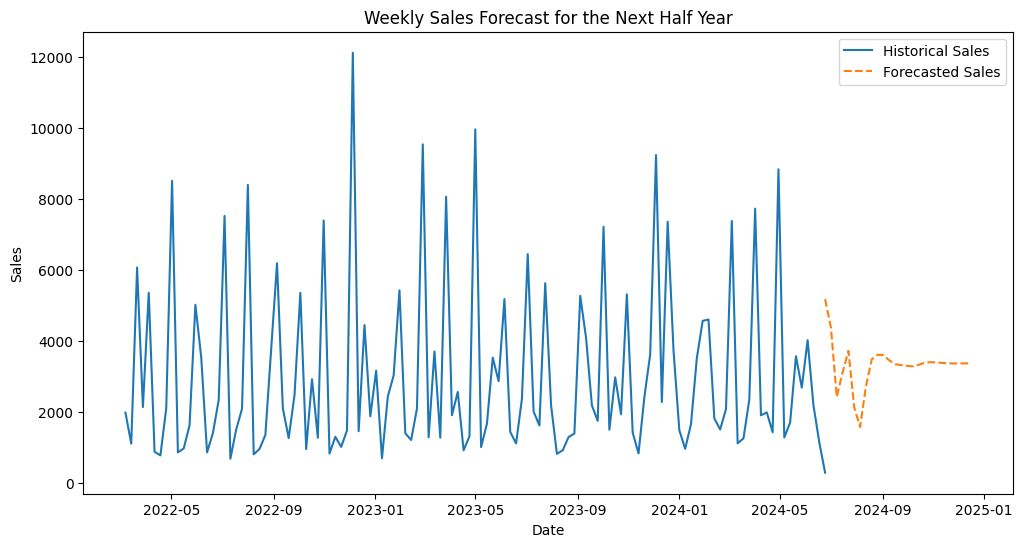

In [58]:
# Skalowanie danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_sales)

# Tworzenie sekwencji dla modelu LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Zmienna docelowa to 'ilosc'
    return np.array(sequences), np.array(labels)

# Definicja długości sekwencji
seq_length = 10

# Sprawdzenie, czy mamy wystarczającą liczbę danych do tworzenia sekwencji
if len(scaled_data) > seq_length:
    # Przygotowanie sekwencji
    X, y = create_sequences(scaled_data, seq_length)

    # Sprawdzenie kształtu danych
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    # Przekształcenie X, aby miało wymiary (próbki, sekwencje, cechy)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Podział danych na zbiór treningowy i testowy
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Budowa modelu LSTM
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Trenowanie modelu
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Prognozowanie sprzedaży na najbliższe pół roku (26 tygodni)
    def predict_next_half_year(model, data, seq_length, steps=26):
        predictions = []
        current_sequence = data[-seq_length:]
        for _ in range(steps):
            current_sequence = current_sequence.reshape((1, seq_length, data.shape[1]))
            pred = model.predict(current_sequence)[0]
            predictions.append(pred)
            current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(np.append(pred, current_sequence[0, -1, 1:]), (1, 1, data.shape[1])), axis=1)
        return np.array(predictions)

    # Prognozowanie na następne 26 tygodni
    predictions = predict_next_half_year(model, scaled_data, seq_length, steps=26)

    # Inwersja skalowania dla prognozowanych wartości
    predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Wyświetlenie prognozowanych wartości
    print(predictions)

    # Wizualizacja prognozowanych wartości
    dates = pd.date_range(start=weekly_sales.index[-1], periods=26, freq='W-Mon')
    forecast = pd.DataFrame(predictions, index=dates, columns=['Predicted Sales'])

    plt.figure(figsize=(12, 6))
    plt.plot(weekly_sales.index, weekly_sales['ilosc'], label='Historical Sales')
    plt.plot(forecast.index, forecast['Predicted Sales'], label='Forecasted Sales', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Weekly Sales Forecast for the Next Half Year')
    plt.legend()
    plt.show()

else:
    print("Niewystarczająca liczba danych do tworzenia sekwencji.")

X shape: (120, 10, 3)
y shape: (120,)
Epoch 1/400


c:\Users\poczt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0840 - val_loss: 0.0597
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0546 - val_loss: 0.0440
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0595 - val_loss: 0.0332
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0397 - val_loss: 0.0396
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0514 - val_loss: 0.0329
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0505 - val_loss: 0.0360
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0486 - val_loss: 0.0329
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0449 - val_loss: 0.0377
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0422 - val_loss: 0.0341
Epoch 10/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0401 - val_loss: 0.0335
Epoch 11/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0480 - val_loss: 0.0328
Epoch 12/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0544 - val_loss: 0.0344


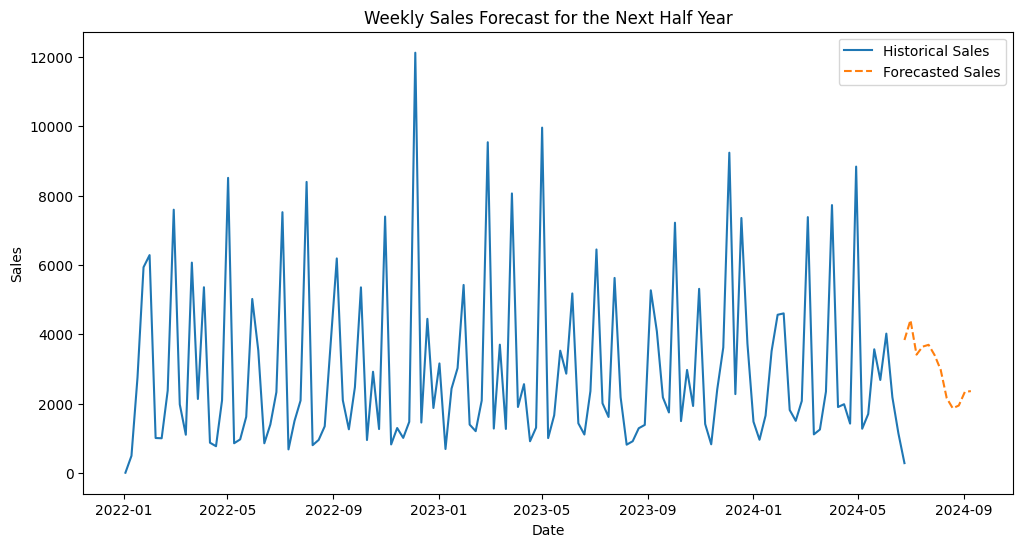

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Wczytanie danych
data = pd.read_csv('prognoza.csv', sep=';', parse_dates=['DATA_W'])

# Pogrupuj dane według kolumny DATA_W i zastosuj odpowiednie agregacje tygodniowe 
data = data.groupby(['DATA_W']).agg({
    'ILOSC': 'sum',
    'ArticleID': 'count',
    'CustomerID': 'nunique'
}).rename(columns={
    'ArticleID': 'articles',
    'CustomerID': 'customers'
}).reset_index()

# Zmiana wszystkich nazw kolumn na małe litery
data.columns = map(str.lower, data.columns)

# Konwersja kolumny 'data_w' na format daty
data['data_w'] = pd.to_datetime(data['data_w'])

# Grupowanie danych według tygodnia, aby uzyskać tygodniową sprzedaż i liczbę klientów
weekly_sales = data.resample('W-Mon', on='data_w').sum().reset_index().sort_values(by='data_w')

# Usunięcie kolumny z datami przed skalowaniem
data_w_dates = weekly_sales['data_w']
weekly_sales_without_dates = weekly_sales.drop(columns=['data_w'])

# Skalowanie danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_sales_without_dates)

# Tworzenie sekwencji dla modelu LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Zmienna docelowa to 'ilosc'
    return np.array(sequences), np.array(labels)

# Definicja długości sekwencji
seq_length = 10

# Sprawdzenie, czy mamy wystarczającą liczbę danych do tworzenia sekwencji
if len(scaled_data) > seq_length:
    # Przygotowanie sekwencji
    X, y = create_sequences(scaled_data, seq_length)

    # Sprawdzenie kształtu danych
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    # Przekształcenie X, aby miało wymiary (próbki, sekwencje, cechy)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    # Podział danych na zbiór treningowy i testowy
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Budowa modelu LSTM
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=(seq_length, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Trenowanie modelu
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Prognozowanie sprzedaży na najbliższe pół roku (26 tygodni)
    def predict_next_half_year(model, data, seq_length, steps=26):
        predictions = []
        current_sequence = data[-seq_length:]
        for _ in range(steps):
            current_sequence = current_sequence.reshape((1, seq_length, data.shape[1]))
            pred = model.predict(current_sequence)[0]
            predictions.append(pred)
            current_sequence = np.append(current_sequence[:, 1:, :], np.reshape(np.append(pred, current_sequence[0, -1, 1:]), (1, 1, data.shape[1])), axis=1)
        return np.array(predictions)

    # Prognozowanie na następne 26 tygodni
    predictions = predict_next_half_year(model, scaled_data, seq_length, steps=12)

    # Inwersja skalowania dla prognozowanych wartości
    predictions = scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

    # Wyświetlenie prognozowanych wartości
    print(predictions)

    # Wizualizacja prognozowanych wartości
    dates = pd.date_range(start=data_w_dates.iloc[-1], periods=12, freq='W-Mon')
    forecast = pd.DataFrame(predictions, index=dates, columns=['Predicted Sales'])

    plt.figure(figsize=(12, 6))
    plt.plot(data_w_dates, weekly_sales['ilosc'], label='Historical Sales')
    plt.plot(forecast.index, forecast['Predicted Sales'], label='Forecasted Sales', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Weekly Sales Forecast for the Next Half Year')
    plt.legend()
    plt.show()

else:
    print("Niewystarczająca liczba danych do tworzenia sekwencji.")
